In [2]:
import pandas as pd
# Excelファイルを読み込む
df = pd.read_excel(r"C:\Users\tears\Desktop\Study\2025\12_CI\004_ML2\Merge_20250815_1.xlsx")
print(df.columns)

Index(['INDEX', '在院日数', '転帰', '平均気温', '平均気圧', 'Month', 'Age', 'Male', 'BMI',
       'NIHSS_aa意識レベル', 'NIHSS_ab質問に対する反応', 'NIHSS_ac命令への反応', 'NIHSS_b最良の注視',
       'NIHSS_c視野', 'NIHSS_d顔面麻痺', 'NIHSS_e上肢の運動右', 'NIHSS_f上肢の運動左',
       'NIHSS_g下肢の運動右', 'NIHSS_h下肢の運動左', 'NIHSS_i四肢の運動失調', 'NIHSS_j感覚',
       'NIHSS_k言語', 'NIHSS_l構音障害', 'NIHSS_m消去無視', 'NIHSS_total score',
       'NIHSS_total_初診時', 'NIHSS_total_24h後', 't-pa', 'エダラボン', '抗てんかん剤', 'RAS',
       'Asprin', 'P2Y12', '睡眠薬', '抗凝固薬', '糖尿病治療薬', 'スタチン', 'β遮断薬', '抗生剤',
       '精神薬', 'リハビリ介入', '脳血栓回収術', '食事', 'ad_APTT', 'ad_Alb', 'ad_BNP',
       'ad_BUN', 'ad_CRP', 'ad_Hb', 'ad_HbA1c', 'ad_K', 'ad_LDL_C', 'ad_Na',
       'ad_PT_INR', 'ad_WBC', 'ad_eGFR', 'hours_48_APTT', 'hours_48_Alb',
       'hours_48_BNP', 'hours_48_BUN', 'hours_48_CRP', 'hours_48_Hb',
       'hours_48_HbA1c', 'hours_48_K', 'hours_48_LDL_C', 'hours_48_Na',
       'hours_48_PT_INR', 'hours_48_WBC', 'hours_48_eGFR', 'hours_48_心拍数',
       'hours_48_非観血_収縮期', '寝返り', '移乗', 

In [ ]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor

# --- 1. データ準備 ---
df = pd.read_excel(r"C:\Users\tears\Desktop\Study\2025\12_CI\004_ML2\Merge_20250815_1.xlsx")
idx_event = df[['INDEX', '在院日数', '転帰']]
df_values = df.drop(columns=['INDEX', '在院日数', '転帰'])

# --- 2. LGBMRegressor を推定器に指定 ---
est_lgb = LGBMRegressor(
    n_estimators=50,      # 木の本数
    learning_rate=0.1,    # 学習率
    n_jobs=-1,            # 全コア並列
    random_state=0
)

imp = IterativeImputer(
    estimator=est_lgb,
    max_iter=5,           # イテレーション回数
    random_state=0,
    initial_strategy='mean'
)

# --- 3. 補完＋結合を一気に実行 ---
df_imputed = pd.concat([
    pd.DataFrame(
        imp.fit_transform(df_values),
        columns=df_values.columns,
        index=df.index
    ),
    idx_event
], axis=1)

# --- 4. 結果確認 ---
print(df_imputed.isna().sum())


In [6]:
# 完全データセットをエクセルファイルに保存
df_imputed.to_excel('completed_data_20250815.xlsx', index=False)

In [14]:
import pandas as pd
completed_data = pd.read_excel(r"C:\Users\tears\Desktop\Study\2025\12_CI\004_ML2\completed_data_20250815.xlsx") 
print(completed_data.columns)

Index(['平均気温', '平均気圧', 'Month', 'Age', 'Male', 'BMI', 'NIHSS_aa意識レベル',
       'NIHSS_ab質問に対する反応', 'NIHSS_ac命令への反応', 'NIHSS_b最良の注視', 'NIHSS_c視野',
       'NIHSS_d顔面麻痺', 'NIHSS_e上肢の運動右', 'NIHSS_f上肢の運動左', 'NIHSS_g下肢の運動右',
       'NIHSS_h下肢の運動左', 'NIHSS_i四肢の運動失調', 'NIHSS_j感覚', 'NIHSS_k言語',
       'NIHSS_l構音障害', 'NIHSS_m消去無視', 'NIHSS_total score', 'NIHSS_total_初診時',
       'NIHSS_total_24h後', 't-pa', 'エダラボン', '抗てんかん剤', 'RAS', 'Asprin', 'P2Y12',
       '睡眠薬', '抗凝固薬', '糖尿病治療薬', 'スタチン', 'β遮断薬', '抗生剤', '精神薬', 'リハビリ介入',
       '脳血栓回収術', '食事', 'ad_APTT', 'ad_Alb', 'ad_BNP', 'ad_BUN', 'ad_CRP',
       'ad_Hb', 'ad_HbA1c', 'ad_K', 'ad_LDL_C', 'ad_Na', 'ad_PT_INR', 'ad_WBC',
       'ad_eGFR', 'hours_48_APTT', 'hours_48_Alb', 'hours_48_BNP',
       'hours_48_BUN', 'hours_48_CRP', 'hours_48_Hb', 'hours_48_HbA1c',
       'hours_48_K', 'hours_48_LDL_C', 'hours_48_Na', 'hours_48_PT_INR',
       'hours_48_WBC', 'hours_48_eGFR', 'hours_48_心拍数', 'hours_48_非観血_収縮期',
       '寝返り', '移乗', '口腔清潔', '食事摂取', '衣服の着脱'

In [59]:
# -*- coding: utf-8 -*-
# ============================================
# 段階版フルコード：MI(時間意識) + GroupKFold + XGBoost + Optuna
#  + EarlyStopping→全学習リフィット + GPUフォールバック + DCA/Calibration
#  + RMSE後方互換 + LOSプール修正 + 実行環境の記録 + SHAP(任意)
# MODE = "quick" | "medium" | "full" で切替
# ============================================

from __future__ import annotations
import os, sys, warnings, pickle, logging, inspect, platform, subprocess
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, List, Tuple, Sequence, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import xgboost as xgb
from xgboost.core import XGBoostError

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

# ─────────────────────────────────────────────
# 0) 基本設定
# ─────────────────────────────────────────────
MODE = "full"  # ← "quick" | "medium" | "full" に変更可

# Excel（時間検証=0/1 を含む、転帰/在院日数/INDEX あり）
RAW_PATH = r"C:\Users\tears\Desktop\Study\2025\12_CI\004_ML2\Merge_20250815_1.xlsx"

# ログ・警告
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

class Config:
    RESULT_DIR = Path(f"results_{datetime.now():%Y%m%d_%H%M}")
    TARGET_COL = "転帰"        # 0/1/2 と一致していること
    LOS_COL = "在院日数"
    INDEX_COL = "INDEX"        # グルーピングに使用
    TIME_FLAG_COL = "時間検証"  # 0: dev, 1: hold
    CLASS_NAMES = ["自宅", "転院", "死亡"]
    RANDOM_STATE = 42
    REG_OBJECTIVE = "reg:squarederror"  # or "count:poisson"

Config.RESULT_DIR.mkdir(exist_ok=True, parents=True)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.FileHandler(Config.RESULT_DIR / "training.log", encoding="utf-8"),
              logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

# ─────────────────────────────────────────────
# 1) 段階パラメータ（MODEで一括切替）
# ─────────────────────────────────────────────
class Tiers:
    QUICK = dict(
        MI_M=3, MI_MAX_ITER=10, MI_SAMPLE_POST=True,
        N_SPLITS=3, N_TRIALS=12, PATIENCE=6, N_BOOT=150,
        BIG_SEARCH=False, ES_ROUNDS=30,
        XGB_N_EST_CLS=300, XGB_N_EST_REG=500, MAX_BIN=128,
        DO_SHAP=False
    )
    MEDIUM = dict(
        MI_M=5, MI_MAX_ITER=15, MI_SAMPLE_POST=True,
        N_SPLITS=4, N_TRIALS=30, PATIENCE=10, N_BOOT=300,
        BIG_SEARCH=False, ES_ROUNDS=50,
        XGB_N_EST_CLS=500, XGB_N_EST_REG=700, MAX_BIN=256,
        DO_SHAP=True
    )
    FULL = dict(
        MI_M=10, MI_MAX_ITER=20, MI_SAMPLE_POST=True,
        N_SPLITS=5, N_TRIALS=80, PATIENCE=20, N_BOOT=600,
        BIG_SEARCH=True, ES_ROUNDS=100,
        XGB_N_EST_CLS=1200, XGB_N_EST_REG=900, MAX_BIN=256,
        DO_SHAP=True
    )

tier = {"quick": Tiers.QUICK, "medium": Tiers.MEDIUM, "full": Tiers.FULL}[MODE.lower()]

# 反映
class MIConfig:
    M: int = tier["MI_M"]
    MAX_ITER: int = tier["MI_MAX_ITER"]
    SAMPLE_POSTERIOR: bool = tier["MI_SAMPLE_POST"]
    SEED: int = 20250815
    USE_STACK_TUNING: bool = True  # ハイパラ探索は各MIのdevを縦結合して一度だけ

Config.N_SPLITS = tier["N_SPLITS"]
Config.N_TRIALS = tier["N_TRIALS"]
Config.PATIENCE = tier["PATIENCE"]
Config.N_BOOT = tier["N_BOOT"]
Config.BIG_SEARCH = tier["BIG_SEARCH"]

ES_ROUNDS = tier["ES_ROUNDS"]
_XGB_N_EST_CLS = tier["XGB_N_EST_CLS"]
_XGB_N_EST_REG = tier["XGB_N_EST_REG"]
_MAX_BIN = tier["MAX_BIN"]
DO_SHAP = tier["DO_SHAP"]

logger.info(f"MODE={MODE} | {tier}")

# ─────────────────────────────────────────────
# 2) 環境情報の保存（論文化用の再現性）
# ─────────────────────────────────────────────
def save_environment_snapshot(out_dir: Path):
    try:
        txt = []
        txt.append(f"Python: {sys.version}")
        txt.append(f"Platform: {platform.platform()}")
        txt.append(f"xgboost: {xgb.__version__}")
        try:
            import sklearn
            txt.append(f"scikit-learn: {sklearn.__version__}")
        except Exception:
            pass
        # pip freeze
        try:
            pkgs = subprocess.check_output([sys.executable, "-m", "pip", "freeze"], text=True)
            (out_dir / "pip_freeze.txt").write_text(pkgs, encoding="utf-8")
        except Exception as e:
            txt.append(f"pip freeze failed: {e}")
        (out_dir / "env_info.txt").write_text("\n".join(txt), encoding="utf-8")
    except Exception as e:
        logger.warning(f"save_environment_snapshot failed: {e}")

save_environment_snapshot(Config.RESULT_DIR)

# ─────────────────────────────────────────────
# 3) GPU 設定（強気） + フォールバック
# ─────────────────────────────────────────────
def gpu_params() -> dict:
    ver = tuple(int(x) for x in xgb.__version__.split(".")[:2])
    if ver >= (2, 0):
        # まず GPU を試し、ダメなら後段のフォールバックでCPUへ
        return dict(tree_method="hist", device="cuda", predictor="gpu_predictor")
    else:
        try:
            import cupy  # noqa
            return dict(tree_method="gpu_hist", predictor="gpu_predictor")
        except Exception:
            return dict(tree_method="hist", predictor="auto")

def fit_with_gpu_fallback_xgb(model, X, y, sample_weight=None, fit_kwargs=None):
    """
    XGBClassifier/Regressor を GPU で学習し、失敗したら CPU にフォールバック。
    sample_weight の二重渡しを抑止する。
    """
    kw = dict(fit_kwargs or {})
    # ---- sample_weight の二重渡し防止 ----
    if "sample_weight" in kw:
        kw.pop("sample_weight")
    if sample_weight is not None:
        kw["sample_weight"] = sample_weight

    try:
        model.fit(X, y, **kw)
        return model, False  # GPU 成功
    except XGBoostError:
        # GPU設定をCPUに切替
        try:
            model.set_params(
                **{k: v for k, v in dict(model.get_params()).items()
                   if k not in ("device", "tree_method", "predictor")}
            )
        except Exception:
            pass
        model.set_params(tree_method="hist", predictor="auto")
        model.fit(X, y, **kw)
        return model, True   # CPU フォールバック

# ─────────────────────────────────────────────
# 4) 前処理 Transformer / 補助関数
# ─────────────────────────────────────────────
class WinsorizeLog1pTransformer(BaseEstimator, TransformerMixin):
    """列ごとの1%-99% winsorize。0以上かつ右歪みが強い列は log1p。"""
    def __init__(self, q_low=0.01, q_high=0.99, skew_thr=1.0):
        self.q_low = q_low
        self.q_high = q_high
        self.skew_thr = skew_thr
        self.quantiles_: Dict[str, Tuple[float, float]] = {}
        self.log_cols_: List[str] = []
        self.columns_: List[str] = []

    def fit(self, X: pd.DataFrame, y=None):
        assert isinstance(X, pd.DataFrame)
        self.columns_ = list(X.columns)
        for c in self.columns_:
            s = pd.to_numeric(X[c], errors="coerce")
            lo, hi = np.nanpercentile(s, [self.q_low*100, self.q_high*100])
            self.quantiles_[c] = (lo, hi)
            if (s.min(skipna=True) >= 0) and (abs(s.skew(skipna=True)) > self.skew_thr):
                self.log_cols_.append(c)
        return self

    def transform(self, X: pd.DataFrame):
        Z = X[self.columns_].copy()
        for c in self.columns_:
            s = pd.to_numeric(Z[c], errors="coerce")
            lo, hi = self.quantiles_[c]
            s = s.clip(lo, hi)
            if c in self.log_cols_:
                s = np.log1p(s)
            Z[c] = s.fillna(s.median())
        return Z.values  # ndarrayで返す

    def get_feature_names_out(self):
        return np.array(self.columns_)

def make_sample_weight(y: np.ndarray) -> np.ndarray:
    classes = np.unique(y)
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    wmap = {c: w for c, w in zip(classes, cw)}
    return np.array([wmap[v] for v in y], dtype=float)

def multiclass_brier(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    oh = label_binarize(y_true, classes=np.arange(y_prob.shape[1]))
    return float(np.mean(np.sum((y_prob - oh) ** 2, axis=1)))

def _bootstrap_ci_core(values: List[float], alpha=0.05) -> Tuple[float, float, float]:
    vals = np.array([v for v in values if np.isfinite(v)])
    if len(vals) == 0:
        return np.nan, np.nan, np.nan
    pt = float(np.nanmean(vals))
    lo = float(np.nanpercentile(vals, 100*(alpha/2)))
    hi = float(np.nanpercentile(vals, 100*(1 - alpha/2)))
    return pt, lo, hi

def get_bootstrap_ci(y_true: np.ndarray, y_prob: np.ndarray, n_boot: int = None) -> Dict[str, Tuple[float,float,float]]:
    if n_boot is None:
        n_boot = Config.N_BOOT
    rng = np.random.default_rng(Config.RANDOM_STATE)
    n = len(y_true)

    def _safe_auc(yy, pp, avg):
        try:
            return roc_auc_score(yy, pp, multi_class="ovr", average=avg)
        except Exception:
            return np.nan

    def _safe_ap(yy, pp, avg):
        try:
            yy_oh = label_binarize(yy, classes=np.arange(pp.shape[1]))
            return average_precision_score(yy_oh, pp, average=avg)
        except Exception:
            return np.nan

    auc_w, auc_m, ap_m, brier = [], [], [], []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        yy = y_true[idx]
        pp = y_prob[idx]
        auc_w.append(_safe_auc(yy, pp, "weighted"))
        auc_m.append(_safe_auc(yy, pp, "macro"))
        ap_m.append(_safe_ap(yy, pp, "macro"))
        brier.append(multiclass_brier(yy, pp))

    out = {
        "AUROC_weighted": _bootstrap_ci_core(auc_w),
        "AUROC_macro":    _bootstrap_ci_core(auc_m),
        "AP_macro":       _bootstrap_ci_core(ap_m),
        "Brier":          _bootstrap_ci_core(brier)
    }
    return out

# sklearn 互換 RMSE（古い版対策）
from sklearn.metrics import mean_squared_error as _sk_mse
ArrayLike = Union[np.ndarray, Sequence[float], Sequence[int]]
def rmse_score(y_true: ArrayLike, y_pred: ArrayLike) -> float:
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()
    try:
        return float(_sk_mse(y_true, y_pred, squared=False))
    except TypeError:
        return float(np.sqrt(_sk_mse(y_true, y_pred)))

# ─────────────────────────────────────────────
# 5) 特徴量作成（Δ・月の循環）※時間検証をメタとして保持
# ─────────────────────────────────────────────
features_initial = [
    '平均気温','平均気圧','Month','Age','Male','BMI',
    'NIHSS_total_初診時',
    't-pa','エダラボン','抗てんかん剤','RAS','Asprin','P2Y12',
    '睡眠薬','抗凝固薬','糖尿病治療薬','スタチン','β遮断薬',
    '抗生剤','リハビリ介入','脳血栓回収術','食事',
    'ad_APTT','ad_HbA1c','ad_LDL_C','ad_PT_INR',
    'ad_Alb','ad_BNP','ad_BUN','ad_CRP','ad_Hb',
    'ad_K','ad_Na','ad_WBC','ad_eGFR',
    'hours_48_心拍数','hours_48_非観血_収縮期',
    'NIHSS_ab質問に対する反応','NIHSS_ac命令への反応','NIHSS_b最良の注視','NIHSS_c視野',
    'NIHSS_d顔面麻痺','NIHSS_e上肢の運動右','NIHSS_f上肢の運動左','NIHSS_g下肢の運動右',
    'NIHSS_h下肢の運動左','NIHSS_i四肢の運動失調','NIHSS_j感覚','NIHSS_k言語',
    'NIHSS_l構音障害','NIHSS_m消去無視',
    'TIA','アテローム血栓性梗塞','その他の脳梗塞','ラクナ梗塞','心原性脳塞栓','脳出血'
]
DELTA_TARGETS = ['Alb','BNP','BUN','CRP','Hb','K','Na','WBC','eGFR']

def signed_log1p(x: pd.Series) -> pd.Series:
    return np.sign(x) * np.log1p(np.abs(x))

def build_features_no_impute(df: pd.DataFrame, keep_meta: bool = True) -> pd.DataFrame:
    out = df.copy()
    created = []
    for col in DELTA_TARGETS:
        ad_col = f"ad_{col}"; d3_col = f"hours_48_{col}"
        if ad_col in out.columns and d3_col in out.columns:
            out[f"delta_{col}"] = out[d3_col] - out[ad_col]
            out[f"delta_pct_{col}"] = ((out[d3_col] - out[ad_col]) / out[ad_col].replace(0, np.nan)) * 100
            out[f"delta_pct_{col}"] = out[f"delta_pct_{col}"].clip(-500, 500)
            out[f"delta_slog_{col}"] = signed_log1p(out[f"delta_{col}"])
            created += [f"delta_{col}", f"delta_pct_{col}", f"delta_slog_{col}"]

    # 48h採血（バイタル以外）は削除
    drop_cols = [c for c in out.columns if c.startswith("hours_48_")
                 and c not in ("hours_48_心拍数", "hours_48_非観血_収縮期")]
    out.drop(columns=drop_cols, inplace=True, errors='ignore')

    extra = []
    if 'Month' in out.columns:
        out['Month_sin'] = np.sin(2 * np.pi * (out['Month'].astype(float) / 12.0))
        out['Month_cos'] = np.cos(2 * np.pi * (out['Month'].astype(float) / 12.0))
        extra += ['Month_sin','Month_cos']

    base_cols = [c for c in features_initial if c in out.columns]
    use_cols = base_cols + [c for c in created if c in out.columns] + extra

    dt = out[use_cols].copy()
    if keep_meta:
        for mc in [Config.TARGET_COL, Config.LOS_COL, Config.INDEX_COL, Config.TIME_FLAG_COL]:
            if mc in out.columns and mc not in dt.columns:
                dt[mc] = out[mc]

    for c in dt.columns:
        if dt[c].dtype == bool:
            dt[c] = dt[c].astype(int)
    return dt

# ─────────────────────────────────────────────
# 6) 多重代入（MICE, dev で fit → hold は transform）
# ─────────────────────────────────────────────
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

META_COLS = [Config.TARGET_COL, Config.LOS_COL, Config.INDEX_COL, Config.TIME_FLAG_COL]

def _iterative_imputer(seed: int) -> IterativeImputer:
    return IterativeImputer(
        random_state=seed,
        max_iter=MIConfig.MAX_ITER,
        sample_posterior=MIConfig.SAMPLE_POSTERIOR,
        skip_complete=True,
        tol=1e-3,
        imputation_order="ascending",
        n_nearest_features=None,
        min_value=None, max_value=None
    )

def multiple_impute_then_build(raw_df: pd.DataFrame,
                               feature_builder_fn,
                               features_needed: List[str]) -> List[pd.DataFrame]:
    df = raw_df.copy()
    if Config.TARGET_COL not in df.columns:
        raise RuntimeError(f"入力データに '{Config.TARGET_COL}' がありません。")
    df = df[~df[Config.TARGET_COL].isna()].copy()

    if Config.TIME_FLAG_COL not in df.columns:
        raise RuntimeError(f"時間検証カラム '{Config.TIME_FLAG_COL}' がありません（0/1必須）。")

    core_cols = [c for c in features_needed if c in df.columns]
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in META_COLS]
    impute_cols = sorted(set(core_cols + num_cols))

    msk_dev = (df[Config.TIME_FLAG_COL] == 0)
    imputed_list: List[pd.DataFrame] = []
    rng = np.random.default_rng(MIConfig.SEED)

    for _ in range(MIConfig.M):
        seed = int(rng.integers(1, 10_000_000))
        imp = _iterative_imputer(seed)

        Xd = df.loc[msk_dev,  impute_cols].astype(float)
        Xh = df.loc[~msk_dev, impute_cols].astype(float)

        imp.fit(Xd)                     # devのみで学習（リーク回避）
        Xd_imp = imp.transform(Xd)
        Xh_imp = imp.transform(Xh)

        imputed = df.copy()
        imputed.loc[msk_dev,  impute_cols] = Xd_imp
        imputed.loc[~msk_dev, impute_cols] = Xh_imp

        dt = feature_builder_fn(imputed, keep_meta=True)
        imputed_list.append(dt)

    return imputed_list

# ─────────────────────────────────────────────
# 7) ES コールバック・可視化ユーティリティ
# ─────────────────────────────────────────────
def _build_xgb_fit_kwargs_for_es(
    model: xgb.XGBClassifier,
    X_val: np.ndarray,
    y_val: np.ndarray,
    sample_weight_tr: np.ndarray | None,
    es_rounds: int = 100
) -> dict:
    sig = inspect.signature(model.fit)
    kw: dict = {}
    if sample_weight_tr is not None:
        kw["sample_weight"] = sample_weight_tr
    if "callbacks" in sig.parameters:
        es_cb = xgb.callback.EarlyStopping(rounds=es_rounds, save_best=True, maximize=False)
        kw.update(dict(eval_set=[(X_val, y_val)], callbacks=[es_cb]))
    elif "early_stopping_rounds" in sig.parameters:
        kw.update(dict(eval_set=[(X_val, y_val)], early_stopping_rounds=es_rounds, verbose=False))
    return kw

def save_confusion_matrix_plot(cm: np.ndarray, model_name: str):
    plt.figure(figsize=(7.5, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu",
                     xticklabels=Config.CLASS_NAMES, yticklabels=Config.CLASS_NAMES,
                     cbar_kws={"shrink": .8}, linewidths=.5, linecolor='white')
    ax.set_title(f'Confusion Matrix - {model_name}', pad=12)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    plt.tight_layout()
    plt.savefig(Config.RESULT_DIR / f"{model_name}_cm.png", dpi=200, bbox_inches='tight')
    plt.close()

# ─────────────────────────────────────────────
# 8) 分類器・回帰器の構築 & チューニング（GroupKFold）
# ─────────────────────────────────────────────
def build_estimator(name: str):
    if name == "Logistic":
        mdl = LogisticRegression(max_iter=1500, random_state=Config.RANDOM_STATE)
        space = {"model__C": optuna.distributions.FloatDistribution(1e-4, 1e1, log=True)}
        return mdl, space

    elif name == "XGBoost":
        base_kwargs = dict(
            objective="multi:softprob",
            eval_metric="mlogloss",
            n_estimators=_XGB_N_EST_CLS,
            random_state=Config.RANDOM_STATE,
            **gpu_params()
        )
        mdl = xgb.XGBClassifier(**base_kwargs)
        mdl.set_params(max_bin=_MAX_BIN)
        if Config.BIG_SEARCH:
            space = {
                "model__max_depth":            optuna.distributions.IntDistribution(3, 12),
                "model__learning_rate":        optuna.distributions.FloatDistribution(1e-3, 3e-1, log=True),
                "model__min_child_weight":     optuna.distributions.IntDistribution(1, 20),
                "model__gamma":                optuna.distributions.FloatDistribution(0, 10),
                "model__subsample":            optuna.distributions.FloatDistribution(.5, 1.0),
                "model__colsample_bytree":     optuna.distributions.FloatDistribution(.5, 1.0),
                "model__reg_alpha":            optuna.distributions.FloatDistribution(1e-6, 1e2, log=True),
                "model__reg_lambda":           optuna.distributions.FloatDistribution(1e-6, 1e2, log=True),
            }
        else:
            space = {
                "model__max_depth":            optuna.distributions.IntDistribution(3, 8),
                "model__learning_rate":        optuna.distributions.FloatDistribution(5e-3, 5e-2, log=True),
                "model__min_child_weight":     optuna.distributions.IntDistribution(1, 10),
                "model__gamma":                optuna.distributions.FloatDistribution(0, 4),
                "model__subsample":            optuna.distributions.FloatDistribution(.6, .9),
                "model__colsample_bytree":     optuna.distributions.FloatDistribution(.6, .9),
                "model__reg_alpha":            optuna.distributions.FloatDistribution(1e-4, 1, log=True),
                "model__reg_lambda":           optuna.distributions.FloatDistribution(1e-3, 5, log=True)
            }
        return mdl, space
    else:
        raise ValueError(f"Unsupported model name: {name}")

def build_regressor_and_space():
    reg = xgb.XGBRegressor(
        objective=Config.REG_OBJECTIVE,
        n_estimators=_XGB_N_EST_REG,
        random_state=Config.RANDOM_STATE,
        **gpu_params()
    )
    reg.set_params(max_bin=_MAX_BIN)
    if Config.BIG_SEARCH:
        space = {
            "model__learning_rate":    optuna.distributions.FloatDistribution(1e-3, 3e-1, log=True),
            "model__max_depth":        optuna.distributions.IntDistribution(3, 12),
            "model__min_child_weight": optuna.distributions.IntDistribution(1, 20),
            "model__gamma":            optuna.distributions.FloatDistribution(0, 10),
            "model__subsample":        optuna.distributions.FloatDistribution(.5, 1.0),
            "model__colsample_bytree": optuna.distributions.FloatDistribution(.5, 1.0),
            "model__reg_alpha":        optuna.distributions.FloatDistribution(1e-6, 1e2, log=True),
            "model__reg_lambda":       optuna.distributions.FloatDistribution(1e-6, 1e2, log=True)
        }
    else:
        space = {
            "model__max_depth":        optuna.distributions.IntDistribution(3, 10),
            "model__learning_rate":    optuna.distributions.FloatDistribution(1e-3, 5e-2, log=True),
            "model__min_child_weight": optuna.distributions.IntDistribution(1, 15),
            "model__gamma":            optuna.distributions.FloatDistribution(0, 5),
            "model__subsample":        optuna.distributions.FloatDistribution(.6, .95),
            "model__colsample_bytree": optuna.distributions.FloatDistribution(.6, .95),
            "model__reg_alpha":        optuna.distributions.FloatDistribution(1e-4, 10, log=True),
            "model__reg_lambda":       optuna.distributions.FloatDistribution(1e-4, 10, log=True)
        }
    return reg, space

def tune_hyperparameters(pipe: Pipeline, space: Dict, X: pd.DataFrame, y: np.ndarray, groups: np.ndarray):
    # GroupKFold でリーク耐性（層別は諦める）
    cv = GroupKFold(n_splits=Config.N_SPLITS)

    def objective(trial: optuna.Trial) -> float:
        params = {}
        for k, d in space.items():
            if isinstance(d, optuna.distributions.FloatDistribution):
                params[k] = trial.suggest_float(k, d.low, d.high, log=d.log)
            elif isinstance(d, optuna.distributions.IntDistribution):
                params[k] = trial.suggest_int(k, d.low, d.high, step=d.step)
            else:
                params[k] = trial.suggest_categorical(k, d.choices)

        pipe.set_params(**params)

        classes = np.unique(y)
        oof = np.zeros((len(y), len(classes)), dtype=np.float32)

        for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(X, y, groups), 1):
            Xtr, ytr = X.iloc[tr_idx], y[tr_idx]
            Xva, yva = X.iloc[va_idx], y[va_idx]

            # dev-train / dev-val（早期終了）→ best_iter を得る
            Xtr_tr, Xtr_ev, ytr_tr, ytr_ev = train_test_split(
                Xtr, ytr, test_size=0.10, stratify=None, random_state=Config.RANDOM_STATE
            )
            pre = clone(pipe.named_steps['pre']).fit(Xtr_tr, ytr_tr)
            Xtr_tr_t = pre.transform(Xtr_tr)
            Xtr_ev_t = pre.transform(Xtr_ev)

            model = clone(pipe.named_steps['model'])
            sw = make_sample_weight(ytr_tr)
            fit_kwargs = {}
            if isinstance(model, xgb.XGBClassifier):
                fit_kwargs = _build_xgb_fit_kwargs_for_es(model, Xtr_ev_t, ytr_ev, sw, es_rounds=ES_ROUNDS)

            # ES 学習
            model_es, _ = fit_with_gpu_fallback_xgb(model, Xtr_tr_t, ytr_tr, sample_weight=sw, fit_kwargs=fit_kwargs)
            best_iter = int(getattr(model_es, "best_iteration", None) or getattr(model_es, "best_ntree_limit", model_es.get_params().get("n_estimators", _XGB_N_EST_CLS)))

            # dev 全体でリフィット
            pre_full = clone(pipe.named_steps['pre']).fit(Xtr, ytr)
            Xtr_full_t = pre_full.transform(Xtr)
            Xva_t      = pre_full.transform(Xva)
            model_full = clone(model_es).set_params(n_estimators=best_iter)
            sw_full = make_sample_weight(ytr)
            model_full, _ = fit_with_gpu_fallback_xgb(model_full, Xtr_full_t, ytr, sample_weight=sw_full)

            oof[va_idx] = model_full.predict_proba(Xva_t)

            # 途中経過（任意）
            try:
                part_auc = roc_auc_score(y[va_idx], oof[va_idx], multi_class="ovr", average="weighted")
                trial.report(part_auc, step=fold_idx)
                if trial.should_prune():
                    raise optuna.TrialPruned()
            except Exception:
                pass

        return roc_auc_score(y, oof, multi_class="ovr", average="weighted")

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=Config.RANDOM_STATE),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=1)
    )
    early_stop = lambda s, t: s.stop() if len(s.trials) - s.best_trial.number > Config.PATIENCE else None
    study.optimize(objective, n_trials=Config.N_TRIALS, callbacks=[early_stop], show_progress_bar=True)

    pipe.set_params(**study.best_params)
    best_params = {k.replace("model__", ""): v for k, v in study.best_params.items()}
    return pipe, best_params

def cv_predict_regression_group(pipe: Pipeline, X: pd.DataFrame, y: np.ndarray, groups: np.ndarray) -> np.ndarray:
    cv = GroupKFold(n_splits=Config.N_SPLITS)
    oof = np.zeros(len(y), dtype=float)
    for tr_idx, va_idx in cv.split(X, y, groups):
        Xtr, ytr = X.iloc[tr_idx], y[tr_idx]
        Xva = X.iloc[va_idx]
        ytr_log = np.log1p(ytr)
        p = clone(pipe)
        p.fit(Xtr, ytr_log)
        pred_log = p.predict(Xva)
        oof[va_idx] = np.expm1(pred_log).clip(0, None)
    return oof

def tune_regression(pipe: Pipeline, space: Dict, X: pd.DataFrame, y: np.ndarray, groups: np.ndarray):
    def objective(trial: optuna.Trial) -> float:
        params = {}
        for k, d in space.items():
            if isinstance(d, optuna.distributions.FloatDistribution):
                params[k] = trial.suggest_float(k, d.low, d.high, log=d.log)
            elif isinstance(d, optuna.distributions.IntDistribution):
                params[k] = trial.suggest_int(k, d.low, d.high, step=d.step)
            else:
                params[k] = trial.suggest_categorical(k, d.choices)
        pipe.set_params(**params)
        oof = cv_predict_regression_group(pipe, X, y, groups)
        rmse = rmse_score(y, oof)   # 後方互換ヘルパ
        return -rmse
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=Config.RANDOM_STATE),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=1)
    )
    early_stop = lambda s, t: s.stop() if len(s.trials) - s.best_trial.number > Config.PATIENCE else None
    study.optimize(objective, n_trials=Config.N_TRIALS, callbacks=[early_stop], show_progress_bar=True)
    pipe.set_params(**study.best_params)
    best_params = {k.replace("model__", ""): v for k, v in study.best_params.items()}
    return pipe, best_params

# ─────────────────────────────────────────────
# 9) 時間検証 split / スタック
# ─────────────────────────────────────────────
def prepare_from_dt_timeaware(dt_with_meta: pd.DataFrame) -> Tuple[pd.DataFrame, np.ndarray, pd.DataFrame, np.ndarray]:
    for col in [Config.TARGET_COL, Config.TIME_FLAG_COL]:
        if col not in dt_with_meta.columns:
            raise RuntimeError(f"dt_with_meta に '{col}' がありません。")
    y = pd.to_numeric(dt_with_meta[Config.TARGET_COL], errors="coerce").astype(int).to_numpy()

    meta_cols = [c for c in [Config.TARGET_COL, Config.LOS_COL, Config.INDEX_COL, Config.TIME_FLAG_COL]
                 if c in dt_with_meta.columns]
    X = dt_with_meta.drop(columns=meta_cols)

    msk_hold = (dt_with_meta[Config.TIME_FLAG_COL] == 1).to_numpy()
    dev_X, hold_X = X.loc[~msk_hold], X.loc[msk_hold]
    dev_y, hold_y = y[~msk_hold], y[msk_hold]
    logger.info(f"Temporal split: dev={len(dev_X)}, hold={len(hold_X)} (flag=1 as hold)")
    return dev_X, dev_y, hold_X, hold_y

def stack_for_tuning_class(dt_list: List[pd.DataFrame]) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    Xs, ys, gs = [], [], []
    for dt in dt_list:
        Xd, yd, _, _ = prepare_from_dt_timeaware(dt)
        Xs.append(Xd); ys.append(yd)
        gs.append(dt.loc[Xd.index, Config.INDEX_COL].values)
    return pd.concat(Xs, axis=0), np.concatenate(ys, axis=0), np.concatenate(gs, axis=0)

def stack_for_tuning_reg(dt_list: List[pd.DataFrame]) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    Xs, ys, gs = [], [], []
    for dt in dt_list:
        Xd, _, _, _ = prepare_from_dt_timeaware(dt)
        ylos_d = dt.loc[Xd.index, Config.LOS_COL].astype(float).to_numpy()
        Xs.append(Xd); ys.append(ylos_d)
        gs.append(dt.loc[Xd.index, Config.INDEX_COL].values)
    return pd.concat(Xs, axis=0), np.concatenate(ys, axis=0), np.concatenate(gs, axis=0)

def split_indices_from_first(dt_list: List[pd.DataFrame]) -> Tuple[np.ndarray, np.ndarray]:
    dt0 = dt_list[0]
    assert Config.INDEX_COL in dt0.columns, "INDEX 列が必要です。"
    msk_hold = (dt0[Config.TIME_FLAG_COL] == 1).to_numpy()
    idx_all = dt0.index.to_numpy()
    return idx_all[~msk_hold], idx_all[msk_hold]

# ─────────────────────────────────────────────
# 10) 実行フロー：MI → スタックチューニング → 各MI学習 → プール
# ─────────────────────────────────────────────
# 10-1) 読み込み
raw = pd.read_excel(RAW_PATH)
logger.info(f"Raw shape: {raw.shape}")

# 10-2) MI → 特徴量生成（Δ・月sin/cos）→ dt_list
dt_list = multiple_impute_then_build(
    raw_df=raw,
    feature_builder_fn=build_features_no_impute,
    features_needed=features_initial + [f"ad_{c}" for c in DELTA_TARGETS] + [f"hours_48_{c}" for c in DELTA_TARGETS]
)
dt_preview = dt_list[0].copy()
dt_preview.to_csv(Config.RESULT_DIR / "dt_with_meta_preview_MI1.csv", index=True, encoding="utf-8-sig")
print("dt_with_meta (MI#1):", dt_preview.shape)

# 10-3) スタックで一度だけハイパラ探索（分類 & 回帰）
if MIConfig.USE_STACK_TUNING:
    Xcls_stack, ycls_stack, gcls_stack = stack_for_tuning_class(dt_list)
    pre_cls = WinsorizeLog1pTransformer()
    base_model_cls, space_cls = build_estimator("XGBoost")
    pipe_cls = Pipeline([("pre", pre_cls), ("model", base_model_cls)])
    tuned_cls, best_cls_params = tune_hyperparameters(pipe_cls, space_cls, Xcls_stack, ycls_stack, gcls_stack)
    logger.info(f"[STACK TUNED - CLASS] {best_cls_params}")
else:
    tuned_cls, best_cls_params = None, None

Xreg_stack, yreg_stack, greg_stack = stack_for_tuning_reg(dt_list)
pre_reg = WinsorizeLog1pTransformer()
reg_base, reg_space = build_regressor_and_space()
pipe_reg = Pipeline([("pre", pre_reg), ("model", reg_base)])
tuned_reg_global, best_reg_params = tune_regression(pipe_reg, reg_space, Xreg_stack, yreg_stack, greg_stack)
logger.info(f"[STACK TUNED - REG] {best_reg_params}")

# 10-4) 各MIで学習→HOLD 予測格納
hold_proba_list: List[pd.DataFrame] = []
hold_pred_los_list: List[pd.DataFrame] = []
per_imp_metrics: List[Dict] = []
device_records: List[str] = []

dev_idx, hold_idx = split_indices_from_first(dt_list)

for i, dt in enumerate(dt_list, 1):
    logger.info(f"===== MI #{i} / {MIConfig.M} =====")
    Xd, yd, Xh, yh = prepare_from_dt_timeaware(dt)

    # ── 分類：pre fit → ES → best_iter で dev 全体リフィット → hold 予測
    pre = WinsorizeLog1pTransformer().fit(Xd, yd)
    Xd_tr = pre.transform(Xd)
    Xh_tr = pre.transform(Xh)

    base_model, _ = build_estimator("XGBoost")
    if best_cls_params is not None:
        base_model.set_params(**best_cls_params)

    Xtr_tr, Xtr_ev, ytr_tr, ytr_ev = train_test_split(
        Xd_tr, yd, test_size=0.10, random_state=Config.RANDOM_STATE
    )
    sw = make_sample_weight(ytr_tr)
    fit_kwargs = _build_xgb_fit_kwargs_for_es(base_model, Xtr_ev, ytr_ev, sw, es_rounds=ES_ROUNDS)

    cls_es, used_cpu = fit_with_gpu_fallback_xgb(
        clone(base_model), Xtr_tr, ytr_tr, sample_weight=sw, fit_kwargs=fit_kwargs
    )
    best_iter = int(getattr(cls_es, "best_iteration", None) or getattr(cls_es, "best_ntree_limit", cls_es.get_params().get("n_estimators", _XGB_N_EST_CLS)))

    cls_full = clone(base_model).set_params(n_estimators=best_iter)
    sw_full = make_sample_weight(yd)
    cls_full, used_cpu2 = fit_with_gpu_fallback_xgb(cls_full, Xd_tr, yd, sample_weight=sw_full)
    device_records.append(f"MI#{i} CLASS: {'CPU' if (used_cpu or used_cpu2) else 'GPU'} (best_iter={best_iter})")

    proba = cls_full.predict_proba(Xh_tr)
    auroc = roc_auc_score(yh, proba, multi_class="ovr", average="weighted")
    brier = multiclass_brier(yh, proba)
    cm = confusion_matrix(yh, np.argmax(proba, axis=1))
    per_imp_metrics.append({"MI": i, "AUROC_weighted": auroc, "Brier": brier})

    idx_hold = dt.loc[hold_idx, Config.INDEX_COL].to_numpy()
    df_proba = pd.DataFrame(proba, index=idx_hold, columns=[f"proba_{c}" for c in Config.CLASS_NAMES])
    hold_proba_list.append(df_proba)

    # 前処理器の保存（再現性）
    with open(Config.RESULT_DIR / f"winsorizer_MI{i}.pkl", "wb") as f:
        pickle.dump(pre, f)

    # ── 回帰（在院日数）：log学習 → 予測戻し
    pre_r = WinsorizeLog1pTransformer().fit(Xd, yd)  # yは未使用
    Xd_tr_r = pre_r.transform(Xd)
    Xh_tr_r = pre_r.transform(Xh)

    reg_model, _ = build_regressor_and_space()
    reg_model.set_params(**best_reg_params)

    ylos_d = dt.loc[Xd.index, Config.LOS_COL].astype(float).to_numpy()
    ytr_log = np.log1p(ylos_d)

    reg_es, used_cpu_r = fit_with_gpu_fallback_xgb(clone(reg_model), Xd_tr_r, ytr_log)
    reg_pred_log = reg_es.predict(Xh_tr_r)
    yhat_los = np.expm1(reg_pred_log).clip(0, None)

    hold_pred_los_list.append(pd.DataFrame({f"在院日数予測_MI{i}": yhat_los}, index=idx_hold))
    device_records.append(f"MI#{i} REG: {'CPU' if used_cpu_r else 'GPU'}")

    # ── SHAP（オプション、MI#1のみ）
    if DO_SHAP and i == 1:
        try:
            import shap
            shap.utils._log.setLevel(logging.WARNING)
            SAMPLE_BG = min(600, Xd_tr.shape[0])
            rng = np.random.default_rng(Config.RANDOM_STATE)
            bg = Xd_tr[rng.choice(Xd_tr.shape[0], SAMPLE_BG, replace=False)]
            try:
                explainer = shap.TreeExplainer(cls_full, data=bg, feature_perturbation="interventional")
            except Exception:
                explainer = shap.Explainer(cls_full, bg)
            MAX_EVAL = min(2000, Xh_tr.shape[0])
            X_eval = Xh_tr[:MAX_EVAL]
            sv = explainer(X_eval)
            vals = getattr(sv, "values", sv)
            if vals.ndim == 2:
                vals = vals[:, None, :]
            feat_names = Xd.columns.tolist()
            mean_abs = np.abs(vals).mean(axis=0).mean(axis=0)
            gi = pd.Series(mean_abs, index=feat_names).sort_values(ascending=False)
            gi.to_csv(Config.RESULT_DIR / f"XGB_MI1_SHAP_global_importance.csv", encoding="utf-8-sig")
        except Exception as e:
            logger.info(f"SHAP error (MI#1): {e}")

# 10-5) MIプール：確率は列名一致で平均、LOSは行方向平均→1列
proba_concat = pd.concat(hold_proba_list, axis=1)
proba_mean = pd.DataFrame(index=proba_concat.index.unique())
for cname in Config.CLASS_NAMES:
    cols = [c for c in proba_concat.columns if c == f"proba_{cname}"]
    if cols:
        proba_mean[f"proba_{cname}"] = proba_concat[cols].mean(axis=1)

los_concat = pd.concat(hold_pred_los_list, axis=1)   # MI毎の列
los_mean   = los_concat.mean(axis=1).to_frame("在院日数予測")

# 10-6) プール確率で最終評価
yh_true = dt_list[0].loc[hold_idx, Config.TARGET_COL].astype(int).to_numpy()
index_hold = dt_list[0].loc[hold_idx, Config.INDEX_COL].to_numpy()
y_prob = proba_mean.loc[index_hold].values

cm_final = confusion_matrix(yh_true, np.argmax(y_prob, axis=1))
final_ci = get_bootstrap_ci(yh_true, y_prob)

flat = {}
for k, (pt, lo, hi) in final_ci.items():
    flat[k] = pt; flat[f"{k}_95CI_low"] = lo; flat[f"{k}_95CI_high"] = hi
summary_pooled = {"Model": f"XGBoost_MIpooled_{MODE}", **{f"Hold_{k}": v for k, v in flat.items()},
                  "Devices": " | ".join(device_records)}
pd.DataFrame([summary_pooled]).to_excel(Config.RESULT_DIR / f"summary_metrics_MIpooled_{MODE}.xlsx", index=False)

pd.DataFrame(cm_final, index=Config.CLASS_NAMES, columns=Config.CLASS_NAMES)\
  .to_csv(Config.RESULT_DIR / f"XGBoost_cm_MIpooled_{MODE}.csv", encoding="utf-8-sig")
save_confusion_matrix_plot(cm_final, f"XGBoost_MIpooled_{MODE}")



# 10-6b) 在院日数（回帰）の最終評価（MI平均, hold）
from sklearn.metrics import r2_score, median_absolute_error

# hold 真値
ylos_true_hold = dt_list[0].loc[hold_idx, Config.LOS_COL].astype(float).to_numpy()

# MI平均予測を INDEX 順に整列
yhat_los_hold = los_mean.loc[index_hold, "在院日数予測"].to_numpy()

def _mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_pred - y_true) / denom)))

rmse = rmse_score(ylos_true_hold, yhat_los_hold)
mae  = float(np.mean(np.abs(ylos_true_hold - yhat_los_hold)))
medae = median_absolute_error(ylos_true_hold, yhat_los_hold)
mape = _mape(ylos_true_hold, yhat_los_hold)
r2   = r2_score(ylos_true_hold, yhat_los_hold)

los_metrics = {
    "RMSE": rmse,
    "MAE": mae,
    "MedAE": medae,
    "MAPE": mape,
    "R2": r2,
    "N_hold": int(len(ylos_true_hold))
}
pd.DataFrame([los_metrics]).to_csv(
    Config.RESULT_DIR / f"LOS_metrics_hold_MIpooled_{MODE}.csv",
    index=False, encoding="utf-8-sig"
)

# 予測と真値の散布図（y=x）
plt.figure(figsize=(6.2, 5.6))
plt.scatter(ylos_true_hold, yhat_los_hold, s=12, alpha=0.6)
lims = [0, max(np.max(ylos_true_hold), np.max(yhat_los_hold)) * 1.05]
plt.plot(lims, lims, 'k--', label='y = x')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("True LOS"); plt.ylabel("Predicted LOS")
plt.title(f"LOS: True vs Pred (hold) | RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.3f}")
plt.tight_layout()
plt.savefig(Config.RESULT_DIR / f"LOS_scatter_hold_MIpooled_{MODE}.png", dpi=200)
plt.close()

# 残差解析（ヒスト & 残差-予測プロット）
resid = yhat_los_hold - ylos_true_hold

plt.figure(figsize=(6.2, 4.6))
plt.hist(resid, bins=30, color="#4C72B0", alpha=0.85, edgecolor="white")
plt.axvline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Residual (Pred - True)"); plt.ylabel("Count")
plt.title("LOS residual histogram (hold)")
plt.tight_layout()
plt.savefig(Config.RESULT_DIR / f"LOS_residual_hist_hold_{MODE}.png", dpi=200)
plt.close()

plt.figure(figsize=(6.2, 4.6))
plt.scatter(yhat_los_hold, resid, s=10, alpha=0.6)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Predicted LOS"); plt.ylabel("Residual (Pred - True)")
plt.title("Residual vs Predicted (hold)")
plt.tight_layout()
plt.savefig(Config.RESULT_DIR / f"LOS_resid_vs_pred_hold_{MODE}.png", dpi=200)
plt.close()

# Bland-Altman（平均 vs 差）
mean_pair = (yhat_los_hold + ylos_true_hold) / 2.0
diff_pair = yhat_los_hold - ylos_true_hold
ba_mean = float(np.mean(diff_pair))
ba_sd   = float(np.std(diff_pair, ddof=1))
loa_low = ba_mean - 1.96*ba_sd
loa_hi  = ba_mean + 1.96*ba_sd

plt.figure(figsize=(6.6, 5.2))
plt.scatter(mean_pair, diff_pair, s=10, alpha=0.6)
plt.axhline(ba_mean, color="C1", linestyle="-", label=f"Mean diff={ba_mean:.2f}")
plt.axhline(loa_low, color="C3", linestyle="--", label=f"LoA-={loa_low:.2f}")
plt.axhline(loa_hi, color="C3", linestyle="--", label=f"LoA+={loa_hi:.2f}")
plt.xlabel("Mean of True and Pred LOS"); plt.ylabel("Difference (Pred - True)")
plt.title("Bland–Altman (hold)")
plt.legend()
plt.tight_layout()
plt.savefig(Config.RESULT_DIR / f"LOS_bland_altman_hold_{MODE}.png", dpi=200)
plt.close()

# 予測と真値のテーブル（確認用）
pd.DataFrame({
    "INDEX": index_hold,
    "LOS_true": ylos_true_hold,
    "LOS_pred": yhat_los_hold,
    "Residual": resid
}).to_csv(Config.RESULT_DIR / f"LOS_predictions_hold_MIpooled_{MODE}.csv",
         index=False, encoding="utf-8-sig")



# 10-7) 予測CSV（INDEX, 分類予測, 在院日数予測）※MI平均
pred_cls = np.argmax(y_prob, axis=1).astype(int)
pred_df = pd.DataFrame({
    "INDEX": index_hold,
    "分類予測": pred_cls
}).set_index("INDEX").join(los_mean, how="left")
pred_df.reset_index().to_csv(Config.RESULT_DIR / f"predictions_holdout_MIpooled_{MODE}.csv", index=False, encoding="utf-8-sig")

# 10-8) 校正 & DCA
def _calibration_bin_stats(y_true_bin: np.ndarray, p_hat: np.ndarray, n_bins: int = 10):
    df = pd.DataFrame({"y": y_true_bin.astype(int), "p": p_hat})
    df = df.sort_values("p").reset_index(drop=True)
    df["bin"] = pd.qcut(df["p"].rank(method="first"), q=n_bins, labels=False, duplicates="drop")
    grouped = df.groupby("bin", observed=True)
    out = pd.DataFrame({
        "pred_mean": grouped["p"].mean(),
        "obs_rate":  grouped["y"].mean(),
        "count":     grouped.size()
    })
    return out.dropna()

def _logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def calibration_plots_and_metrics(y_true: np.ndarray, y_proba: np.ndarray, class_names: List[str], prefix: str):
    n_classes = y_proba.shape[1]
    rows = []
    for c in range(n_classes):
        y_bin = (y_true == c).astype(int)
        p_hat = y_proba[:, c]
        bin_df = _calibration_bin_stats(y_bin, p_hat, n_bins=10)
        ece = np.average(np.abs(bin_df["obs_rate"] - bin_df["pred_mean"]), weights=bin_df["count"])

        X = _logit(p_hat).reshape(-1, 1)
        try:
            lr = LogisticRegression(C=1e6, solver="lbfgs")
            lr.fit(X, y_bin)
            slope = float(lr.coef_.ravel()[0])
            intercept = float(lr.intercept_.ravel()[0])
        except Exception:
            slope, intercept = np.nan, np.nan

        rows.append({
            "class_id": c, "class_name": class_names[c] if c < len(class_names) else str(c),
            "ECE": ece, "Calib_slope": slope, "Calib_intercept": intercept
        })

        plt.figure(figsize=(5.8, 5.5))
        plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect")
        plt.plot(bin_df["pred_mean"], bin_df["obs_rate"], marker="o", linewidth=1.8, label="Model")
        ax = plt.gca()
        ax2 = ax.twinx()
        ax2.bar(bin_df["pred_mean"], bin_df["count"], width=0.07, alpha=0.25, edgecolor="none")
        ax2.set_ylabel("Count (per bin)")
        ax.set_xlabel("Predicted probability")
        ax.set_ylabel("Observed frequency")
        ax.set_title(f"Calibration: {class_names[c] if c < len(class_names) else c}")
        ax.legend(loc="upper left")
        plt.tight_layout()
        plt.savefig(Config.RESULT_DIR / f"{prefix}_calibration_class{c}.png", dpi=200)
        plt.close()

    pd.DataFrame(rows).to_csv(Config.RESULT_DIR / f"{prefix}_calibration_metrics.csv",
                              index=False, encoding="utf-8-sig")

def decision_curve(y_true_bin: np.ndarray, p_hat: np.ndarray, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)
    N = len(y_true_bin)
    NB, NB_all = [], []
    for pt in thresholds:
        pred_pos = (p_hat >= pt).astype(int)
        TP = np.sum((pred_pos == 1) & (y_true_bin == 1))
        FP = np.sum((pred_pos == 1) & (y_true_bin == 0))
        nb = (TP / N) - (FP / N) * (pt / (1 - pt))
        TP_all = np.sum(y_true_bin == 1)
        FP_all = np.sum(y_true_bin == 0)
        nb_all = (TP_all / N) - (FP_all / N) * (pt / (1 - pt))
        NB.append(nb); NB_all.append(nb_all)
    NB = np.array(NB); NB_all = np.array(NB_all)
    NB_none = np.zeros_like(NB)
    return thresholds, NB, NB_all, NB_none

def plot_dca_multiclass(y_true: np.ndarray, y_proba: np.ndarray, class_names: List[str], prefix: str):
    n_classes = y_proba.shape[1]
    plt.figure(figsize=(7.8, 6.2))
    thresholds = np.linspace(0.01, 0.80, 80)
    for c in range(n_classes):
        y_bin = (y_true == c).astype(int)
        p_hat = y_proba[:, c]
        th, NB, NB_all, NB_none = decision_curve(y_bin, p_hat, thresholds)
        label = f"{class_names[c] if c < len(class_names) else c}"
        plt.plot(th, NB, label=f"Model ({label})", linewidth=1.8)
        if c == 0:
            plt.plot(th, NB_all, color="gray", linestyle="--", label="Treat-all")
            plt.plot(th, NB_none, color="black", linestyle=":", label="Treat-none")
    plt.xlabel("Threshold probability (pt)")
    plt.ylabel("Net Benefit")
    plt.title("Decision Curve Analysis (OVR)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(Config.RESULT_DIR / f"{prefix}_DCA_OVR.png", dpi=200)
    plt.close()

calibration_plots_and_metrics(
    y_true=yh_true, y_proba=y_prob, class_names=Config.CLASS_NAMES, prefix=f"XGBoost_MIpooled_{MODE}_holdout"
)
plot_dca_multiclass(
    y_true=yh_true, y_proba=y_prob, class_names=Config.CLASS_NAMES, prefix=f"XGBoost_MIpooled_{MODE}_holdout"
)

# 10-9) 付帯保存
proba_mean.loc[index_hold].to_csv(
    Config.RESULT_DIR / f"predictions_holdout_proba_MIpooled_{MODE}.csv", encoding="utf-8-sig"
)
pd.DataFrame(per_imp_metrics).to_excel(
    Config.RESULT_DIR / f"per_imputation_metrics_{MODE}.xlsx", index=False
)
(Config.RESULT_DIR / "device_records.txt").write_text("\n".join(device_records), encoding="utf-8")

print("完了。出力先:", Config.RESULT_DIR.resolve())


2025-08-15 16:59:53,006 [INFO] MODE=full | {'MI_M': 10, 'MI_MAX_ITER': 20, 'MI_SAMPLE_POST': True, 'N_SPLITS': 5, 'N_TRIALS': 80, 'PATIENCE': 20, 'N_BOOT': 600, 'BIG_SEARCH': True, 'ES_ROUNDS': 100, 'XGB_N_EST_CLS': 1200, 'XGB_N_EST_REG': 900, 'MAX_BIN': 256, 'DO_SHAP': True}
2025-08-15 16:59:54,806 [INFO] Raw shape: (3000, 86)
2025-08-15 17:02:50,645 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 17:02:50,645 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 17:02:50,645 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 17:02:50,645 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 17:02:50,645 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 17:02:50,645 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 17:02:50,663 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 17:02:50,667 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-0

dt_with_meta (MI#1): (3000, 90)


Best trial: 43. Best value: 0.811643:  80%|████████  | 64/80 [1:02:13<15:33, 58.33s/it] 
2025-08-15 18:05:03,686 [INFO] [STACK TUNED - CLASS] {'max_depth': 12, 'learning_rate': 0.007745914425222318, 'min_child_weight': 18, 'gamma': 8.420114543465075, 'subsample': 0.5872490444948715, 'colsample_bytree': 0.5056305867508254, 'reg_alpha': 0.5198653317679335, 'reg_lambda': 3.591189787205119}
2025-08-15 18:05:03,686 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 18:05:03,702 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 18:05:03,705 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 18:05:03,706 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 18:05:03,712 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 18:05:03,712 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 18:05:03,712 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
2025-08-15 18:05:03,721 [INFO

完了。出力先: C:\Users\tears\Desktop\Study\2025\12_CI\004_ML2\results_20250815_1659


In [ ]:
# ============================================
# 論文用：結果テーブル（95% CI付き） & Figure 作成ブロック
# 前提：主コードの実行後で、以下が存在
#   - yh_true: hold の真のクラス (ndarray, shape [n])
#   - y_prob : hold の予測確率 (ndarray, shape [n, n_classes])
#   - index_hold: hold の INDEX 並び (ndarray, shape [n])
#   - los_mean: DataFrame(index=INDEX, col="在院日数予測")  ← MI平均
#   - dt_list, hold_idx, Config: それぞれ主コードで定義済み
# 生成物は Config.RESULT_DIR / "paper" 以下に保存
# ============================================
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, accuracy_score,
    f1_score, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

PAPER_DIR = Config.RESULT_DIR / "paper"
PAPER_DIR.mkdir(exist_ok=True, parents=True)

# ==============
# 汎用ブートストラップCI
# ==============
def bootstrap_ci_stat(stat_fn, y_true, y_pred=None, n_boot=1000, seed=42):
    """
    stat_fn: callable -> float
        例) lambda yt, yp: accuracy_score(yt, yp.argmax(1))
        例) lambda yt, yp: f1_score(yt, yp.argmax(1), average='macro')
        例) lambda yt, yp: rmse_score(yt, yp)  # 回帰など
    y_pred: 分類は y_prob、回帰は連続予測
    """
    rng = np.random.default_rng(seed)
    n = len(y_true)
    vals = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        yt = y_true[idx]
        yp = y_pred[idx] if y_pred is not None else None
        try:
            v = float(stat_fn(yt, yp))
        except Exception:
            v = np.nan
        vals.append(v)
    vals = np.array(vals, float)
    pt = float(np.nanmean(vals))
    lo = float(np.nanpercentile(vals, 2.5))
    hi = float(np.nanpercentile(vals, 97.5))
    return pt, lo, hi

def fmt_ci(pt, lo, hi, decimals=3):
    f = lambda x: f"{x:.{decimals}f}" if np.isfinite(x) else "nan"
    return f"{f(pt)} [{f(lo)}, {f(hi)}]"

# =========================================
# 1) 分類：メインメトリクス（95% CI）テーブル
# =========================================
# 既存の関数 get_bootstrap_ci を使って AUROC/AP/Brier のCIを取得
ci_pack = get_bootstrap_ci(y_true=yh_true, y_prob=y_prob, n_boot=Config.N_BOOT)

# 追加で Accuracy と Macro-F1 の CI をブートストラップ
pred_cls_hold = np.argmax(y_prob, axis=1)
acc_pt, acc_lo, acc_hi = bootstrap_ci_stat(lambda yt, yp: accuracy_score(yt, np.argmax(yp, 1)),
                                           yh_true, y_prob, n_boot=max(500, Config.N_BOOT), seed=Config.RANDOM_STATE)
f1_pt, f1_lo, f1_hi   = bootstrap_ci_stat(lambda yt, yp: f1_score(yt, np.argmax(yp, 1), average='macro'),
                                          yh_true, y_prob, n_boot=max(500, Config.N_BOOT), seed=Config.RANDOM_STATE)

cls_rows = []
# AUROC/AP/Brier（既存関数の出力を整形）
for key, (pt, lo, hi) in ci_pack.items():
    cls_rows.append({
        "Metric": key,
        "Point": pt, "CI_low": lo, "CI_high": hi,
        "Display": fmt_ci(pt, lo, hi, decimals=3)
    })

# Accuracy / Macro-F1 を追加
cls_rows += [
    {"Metric": "Accuracy", "Point": acc_pt, "CI_low": acc_lo, "CI_high": acc_hi, "Display": fmt_ci(acc_pt, acc_lo, acc_hi)},
    {"Metric": "F1_macro", "Point": f1_pt,  "CI_low": f1_lo,  "CI_high": f1_hi,  "Display": fmt_ci(f1_pt,  f1_lo,  f1_hi)},
]
df_cls_table = pd.DataFrame(cls_rows)
df_cls_table.to_csv(PAPER_DIR / "Table_classification_metrics_CI.csv", index=False, encoding="utf-8-sig")
# Excel（見出し整形用）
with pd.ExcelWriter(PAPER_DIR / "Table_classification_metrics_CI.xlsx", engine="xlsxwriter") as w:
    df_cls_table.to_excel(w, index=False, sheet_name="classification")
print("Saved:", (PAPER_DIR / "Table_classification_metrics_CI.*").as_posix())

# =========================================
# 2) 回帰：メインメトリクス（95% CI）テーブル
# =========================================
# 真値・予測（INDEX順整列）
ylos_true_hold = dt_list[0].loc[hold_idx, Config.LOS_COL].astype(float).to_numpy()
yhat_los_hold  = los_mean.loc[index_hold, "在院日数予測"].to_numpy()

from sklearn.metrics import r2_score, median_absolute_error
def _mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_pred - y_true) / denom)))

# ポイント推定
rmse_pt = rmse_score(ylos_true_hold, yhat_los_hold)
mae_pt  = float(np.mean(np.abs(ylos_true_hold - yhat_los_hold)))
medae_pt = median_absolute_error(ylos_true_hold, yhat_los_hold)
mape_pt = _mape(ylos_true_hold, yhat_los_hold)
r2_pt   = r2_score(ylos_true_hold, yhat_los_hold)

# CI（ブートストラップ）
rmse_ci = bootstrap_ci_stat(lambda yt, yp: rmse_score(yt, yp), ylos_true_hold, yhat_los_hold,
                            n_boot=max(1000, Config.N_BOOT), seed=Config.RANDOM_STATE)
mae_ci  = bootstrap_ci_stat(lambda yt, yp: np.mean(np.abs(yt - yp)), ylos_true_hold, yhat_los_hold,
                            n_boot=max(1000, Config.N_BOOT), seed=Config.RANDOM_STATE)
medae_ci= bootstrap_ci_stat(lambda yt, yp: median_absolute_error(yt, yp), ylos_true_hold, yhat_los_hold,
                            n_boot=max(1000, Config.N_BOOT), seed=Config.RANDOM_STATE)
mape_ci = bootstrap_ci_stat(lambda yt, yp: _mape(yt, yp), ylos_true_hold, yhat_los_hold,
                            n_boot=max(1000, Config.N_BOOT), seed=Config.RANDOM_STATE)
r2_ci   = bootstrap_ci_stat(lambda yt, yp: r2_score(yt, yp), ylos_true_hold, yhat_los_hold,
                            n_boot=max(1000, Config.N_BOOT), seed=Config.RANDOM_STATE)

reg_rows = [
    {"Metric": "RMSE",  "Point": rmse_pt,  "CI_low": rmse_ci[1],  "CI_high": rmse_ci[2],  "Display": fmt_ci(*rmse_ci, decimals=2)},
    {"Metric": "MAE",   "Point": mae_pt,   "CI_low": mae_ci[1],   "CI_high": mae_ci[2],   "Display": fmt_ci(*mae_ci,  decimals=2)},
    {"Metric": "MedAE", "Point": medae_pt, "CI_low": medae_ci[1], "CI_high": medae_ci[2], "Display": fmt_ci(*medae_ci,decimals=2)},
    {"Metric": "MAPE",  "Point": mape_pt,  "CI_low": mape_ci[1],  "CI_high": mape_ci[2],  "Display": fmt_ci(*mape_ci, decimals=3)},
    {"Metric": "R2",    "Point": r2_pt,    "CI_low": r2_ci[1],    "CI_high": r2_ci[2],    "Display": fmt_ci(*r2_ci,   decimals=3)},
]
df_reg_table = pd.DataFrame(reg_rows)
df_reg_table.to_csv(PAPER_DIR / "Table_regression_metrics_CI.csv", index=False, encoding="utf-8-sig")
with pd.ExcelWriter(PAPER_DIR / "Table_regression_metrics_CI.xlsx", engine="xlsxwriter") as w:
    df_reg_table.to_excel(w, index=False, sheet_name="regression")
print("Saved:", (PAPER_DIR / "Table_regression_metrics_CI.*").as_posix())

# =========================================
# 3) 図：Multiclass ROC (OVR) with AUC (95% CI)
# =========================================
# クラスごとのROC、マクロ/マイクロ平均の曲線も併記
n_classes = y_prob.shape[1]
classes = list(range(n_classes))
class_names = Config.CLASS_NAMES if len(Config.CLASS_NAMES) == n_classes else [str(i) for i in classes]

# OVRのために one-hot
Y_true_oh = label_binarize(yh_true, classes=classes)

fpr = dict(); tpr = dict(); roc_auc = dict()
for i in classes:
    fpr[i], tpr[i], _ = roc_curve(Y_true_oh[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# マイクロ平均
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_oh.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# マクロ平均（単純平均）
roc_auc["macro"] = float(np.mean([roc_auc[i] for i in classes]))

# 図
plt.figure(figsize=(7.5, 6.2))
plt.plot(fpr["micro"], tpr["micro"], color='k', lw=2, label=f"micro-average ROC (AUC={roc_auc['micro']:.3f})")
for i in classes:
    plt.plot(fpr[i], tpr[i], lw=1.8, label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlim([0,1]); plt.ylim([0,1.02])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("OVR ROC on hold-out")
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.savefig(PAPER_DIR / "Fig_ROC_OVR_hold.png", dpi=300)
plt.close()

# 参考：Weighted/Macro のAUCに 95%CI を注釈用テキストで保存
auroc_w = ci_pack["AUROC_weighted"]; auroc_m = ci_pack["AUROC_macro"]
(Path(PAPER_DIR) / "Fig_ROC_OVR_hold_caption.txt").write_text(
    f"Weighted AUROC = {fmt_ci(*auroc_w, decimals=3)}; "
    f"Macro AUROC = {fmt_ci(*auroc_m, decimals=3)}",
    encoding="utf-8"
)

# =========================================
# 4) 図：Multiclass Precision-Recall (OVR)
# =========================================
plt.figure(figsize=(7.5, 6.2))
for i in classes:
    precision, recall, _ = precision_recall_curve(Y_true_oh[:, i], y_prob[:, i])
    ap = average_precision_score(Y_true_oh[:, i], y_prob[:, i])
    plt.plot(recall, precision, lw=1.8, label=f"{class_names[i]} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("OVR Precision-Recall on hold-out")
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.savefig(PAPER_DIR / "Fig_PR_OVR_hold.png", dpi=300)
plt.close()

# =========================================
# 5) 図：Confusion Matrix（数値＋割合の2種）
# =========================================
cm = confusion_matrix(yh_true, pred_cls_hold, labels=classes)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv(PAPER_DIR / "ConfusionMatrix_counts.csv", encoding="utf-8-sig")

# 割合（行正規化：感度イメージ）
cm_rowpct = cm / cm.sum(axis=1, keepdims=True)
cm_rowpct_df = pd.DataFrame(cm_rowpct, index=class_names, columns=class_names)
cm_rowpct_df.to_csv(PAPER_DIR / "ConfusionMatrix_rowpct.csv", encoding="utf-8-sig")

# 作図（counts）
plt.figure(figsize=(6.2, 5.5))
im = plt.imshow(cm, cmap="Blues")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(n_classes), class_names, rotation=45, ha='right')
plt.yticks(range(n_classes), class_names)
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, f"{cm[i,j]:d}", ha="center", va="center", color="black")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (counts)")
plt.tight_layout()
plt.savefig(PAPER_DIR / "Fig_CM_counts.png", dpi=300)
plt.close()

# 作図（row%）
plt.figure(figsize=(6.2, 5.5))
im = plt.imshow(cm_rowpct, cmap="Greens", vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(n_classes), class_names, rotation=45, ha='right')
plt.yticks(range(n_classes), class_names)
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, f"{cm_rowpct[i,j]*100:.1f}%", ha="center", va="center", color="black")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (row %)")
plt.tight_layout()
plt.savefig(PAPER_DIR / "Fig_CM_rowpct.png", dpi=300)
plt.close()

# =========================================
# 6) 回帰図：Bland–Altman + メトリクスCI注釈
# =========================================
resid = yhat_los_hold - ylos_true_hold
mean_pair = (yhat_los_hold + ylos_true_hold) / 2.0
ba_mean = float(np.mean(resid))
ba_sd   = float(np.std(resid, ddof=1))
loa_low = ba_mean - 1.96*ba_sd
loa_hi  = ba_mean + 1.96*ba_sd

# CI文字列
rmse_txt = fmt_ci(*rmse_ci, decimals=2)
mae_txt  = fmt_ci(*mae_ci,  decimals=2)
r2_txt   = fmt_ci(*r2_ci,   decimals=3)

plt.figure(figsize=(7.0, 5.3))
plt.scatter(mean_pair, resid, s=12, alpha=0.6)
plt.axhline(ba_mean, color="C1", linestyle="-", label=f"Mean diff={ba_mean:.2f}")
plt.axhline(loa_low, color="C3", linestyle="--", label=f"LoA-={loa_low:.2f}")
plt.axhline(loa_hi,  color="C3", linestyle="--", label=f"LoA+={loa_hi:.2f}")
plt.xlabel("Mean of True and Pred LOS"); plt.ylabel("Difference (Pred - True)")
plt.title("Bland–Altman (hold)")
plt.legend(loc="upper right")
# 注釈枠（RMSE/MAE/R² の CI）
txt = f"RMSE = {rmse_txt}\nMAE = {mae_txt}\nR² = {r2_txt}\nN = {len(ylos_true_hold)}"
plt.gca().text(0.02, 0.02, txt, transform=plt.gca().transAxes,
               fontsize=10, va="bottom", ha="left",
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor="gray"))
plt.tight_layout()
plt.savefig(PAPER_DIR / "Fig_LOS_BlandAltman_hold.png", dpi=300)
plt.close()

# =========================================
# 7) 論文添付用まとめ Excel（1ファイルにシート集約）
# =========================================
with pd.ExcelWriter(PAPER_DIR / "Paper_Tables_FigRefs.xlsx", engine="xlsxwriter") as w:
    df_cls_table.to_excel(w, index=False, sheet_name="Classification_CI")
    df_reg_table.to_excel(w, index=False, sheet_name="Regression_CI")
    # 混同行列（数/行%）
    cm_df.to_excel(w, sheet_name="CM_counts")
    cm_rowpct_df.to_excel(w, sheet_name="CM_rowpct")
    # 図のファイルパス一覧
    fig_paths = pd.DataFrame({
        "Figure": ["Fig_ROC_OVR_hold.png", "Fig_PR_OVR_hold.png", "Fig_CM_counts.png",
                   "Fig_CM_rowpct.png", "Fig_LOS_BlandAltman_hold.png"],
        "Path": [str((PAPER_DIR / f).resolve()) for f in
                 ["Fig_ROC_OVR_hold.png", "Fig_PR_OVR_hold.png", "Fig_CM_counts.png",
                  "Fig_CM_rowpct.png", "Fig_LOS_BlandAltman_hold.png"]]
    })
    fig_paths.to_excel(w, index=False, sheet_name="Figure_files")

print("Paper-ready tables & figures saved to:", PAPER_DIR.resolve())


In [60]:
# =========================
# SHAP 解析（このブロックは学習コードの「後」に貼って実行）
# - MI#1 の dev で XGBoost を再学習（ES→best_iter→全データリフィット）
# - hold を対象に SHAP を計算
# - 返り配列の軸順を自動判別し (samples, classes, features) へ正規化
# - 成果物は Config.RESULT_DIR / "shap" 以下へ保存
# =========================

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.base import clone as _clone

# SHAPログ抑制（新バージョン対応）
logging.getLogger("shap").setLevel(logging.WARNING)

SHAP_DIR = Config.RESULT_DIR / "shap"
SHAP_DIR.mkdir(exist_ok=True, parents=True)

# === 1) データ準備（MI#1 の dev/hold） ===
dt = dt_list[0]
Xd, yd, Xh, yh = prepare_from_dt_timeaware(dt)

# === 2) 前処理 & 再学習（GPU→CPU フォールバック + ES→全学習リフィット） ===
pre = WinsorizeLog1pTransformer().fit(Xd, yd)
Xd_t = pre.transform(Xd)
Xh_t = pre.transform(Xh)

# 分類器をベストパラメータで構築
base_model, _ = build_estimator("XGBoost")
if 'best_cls_params' in globals() and best_cls_params is not None:
    base_model.set_params(**best_cls_params)

# 早期終了のための小検証セット
Xtr_tr, Xtr_ev, ytr_tr, ytr_ev = train_test_split(
    Xd_t, yd, test_size=0.10, random_state=Config.RANDOM_STATE
)
sw = make_sample_weight(ytr_tr)
fit_kwargs = _build_xgb_fit_kwargs_for_es(base_model, Xtr_ev, ytr_ev, sw, es_rounds=ES_ROUNDS)

# GPU→CPU フォールバックで ES 学習
cls_es, used_fallback_es = fit_with_gpu_fallback_xgb(
    base_model, Xtr_tr, ytr_tr, sample_weight=sw, fit_kwargs=fit_kwargs
)

# best_iter 決定
best_iter = int(
    getattr(cls_es, "best_iteration", None)
    or getattr(cls_es, "best_ntree_limit", cls_es.get_params().get("n_estimators", _XGB_N_EST_CLS))
)

# 全 dev でリフィット
cls_full = _clone(base_model).set_params(n_estimators=best_iter)
sw_full = make_sample_weight(yd)
cls_full, used_fallback_full = fit_with_gpu_fallback_xgb(cls_full, Xd_t, yd, sample_weight=sw_full)

# === 3) SHAP 値の計算（メモリ節約のためサンプル） ===
feat_names = Xd.columns.tolist()
n_features_expected = X_eval_feat_count = Xd_t.shape[1]  # 変換後の特徴次元

# 背景を dev からサンプリング
SAMPLE_BG = min(800, Xd_t.shape[0])
rng = np.random.default_rng(Config.RANDOM_STATE)
bg_idx = rng.choice(Xd_t.shape[0], SAMPLE_BG, replace=False)
bg = Xd_t[bg_idx]

# 評価対象（hold）もサンプリング可能
MAX_EVAL = 2000  # hold が大きい時の上限
if Xh_t.shape[0] <= MAX_EVAL:
    eval_idx = np.arange(Xh_t.shape[0])
else:
    eval_idx = rng.choice(Xh_t.shape[0], MAX_EVAL, replace=False)
X_eval = Xh_t[eval_idx]
y_eval = yh[eval_idx]

# TreeExplainer 優先（失敗時は汎用 Explainer）
try:
    explainer = shap.TreeExplainer(cls_full, data=bg, feature_perturbation="interventional")
except Exception:
    explainer = shap.Explainer(cls_full, bg)

sv_raw = explainer(X_eval)

# === 3.1) SHAP 配列を (samples, classes, features) に正規化 ===
def _to_scf(sv_obj, X_eval):
    """sv_obj を (samples, classes, features) に正規化して返す"""
    # パターンA: 古いAPIで list[Explanation]（クラス数のリスト）
    if isinstance(sv_obj, list):
        arr = np.stack([s.values for s in sv_obj], axis=1)  # (samples, classes, features)
        return arr

    # パターンB: Explanation。values の形状がバージョンで揺れる
    vals = getattr(sv_obj, "values", sv_obj)
    arr = np.array(vals)

    # バイナリなど (samples, features) → (samples, 1, features)
    if arr.ndim == 2 and arr.shape[1] == X_eval.shape[1]:
        return arr[:, None, :]

    # 3次元だが軸順不明：候補の転置で末尾=features、先頭=samples になるものを探す
    if arr.ndim == 3:
        s = X_eval.shape[0]
        f = X_eval.shape[1]
        candidates = [
            arr,                          # ( ?, ?, ? )
            np.transpose(arr, (1, 0, 2)),
            np.transpose(arr, (0, 2, 1)),
            np.transpose(arr, (2, 0, 1)),
            np.transpose(arr, (1, 2, 0)),
            np.transpose(arr, (2, 1, 0)),
        ]
        for cand in candidates:
            if cand.shape[0] == s and cand.shape[2] == f:
                return cand  # (samples, classes, features) のはず
        # どうしても決まらない場合は、最後の軸を features に合わせて、残りを sample×class とみなす
        if arr.shape[-1] == f:
            sc = arr.reshape(-1, f)  # (samples*classes, features)
            # クラス数推定（割り切れない場合は 1 とする）
            c_est = max(1, sc.shape[0] // s)
            return sc.reshape(s, c_est, f)

    # 最後の fallback：features 軸だけ合わせて (samples, 1, features) にする
    if arr.ndim >= 1 and arr.shape[-1] == X_eval.shape[1]:
        flat = arr.reshape(-1, X_eval.shape[1])
        return flat[: X_eval.shape[0], :][:, None, :]

    raise ValueError(f"Unexpected SHAP value shape: {arr.shape}")

sv = _to_scf(sv_raw, X_eval)  # (samples, classes, features)
n_samples, n_classes, n_features = sv.shape

# === 4) 重要度の集計・保存 ===
mean_abs_by_class = np.abs(sv).mean(axis=0)            # (n_classes, n_features)
mean_abs_global = mean_abs_by_class.mean(axis=0)       # (n_features,)
global_importance = pd.Series(mean_abs_global, index=feat_names).sort_values(ascending=False)
global_importance.to_csv(SHAP_DIR / "shap_global_importance.csv", encoding="utf-8-sig")

# グローバル上位30のバー図
plt.figure(figsize=(8, 10))
global_importance.iloc[:30][::-1].plot(kind="barh")
plt.title("Mean |SHAP| (global, class-avg)")
plt.tight_layout()
plt.savefig(SHAP_DIR / "shap_bar_global_top30.png", dpi=200)
plt.close()

# === 5) クラス別ビースウォーム（上位特徴のみ、クラス別 expected_value に配慮） ===
TOPK = 20
expected = getattr(explainer, "expected_value", 0.0)

def _class_base_value(c):
    """expected_value の形状の違いに安全に対応してクラス別ベース値を返す"""
    if np.ndim(expected) == 0:
        return float(expected)
    arr = np.array(expected)
    if arr.ndim == 1 and arr.shape[0] == n_classes:
        return float(arr[c])
    return float(arr.mean())

for c in range(n_classes):
    cls_name = Config.CLASS_NAMES[c] if c < len(Config.CLASS_NAMES) else f"class{c}"
    # 上位特徴のインデックス（このクラスでの |SHAP| 平均が大きい順）
    top_idx = np.argsort(mean_abs_by_class[c])[::-1][:TOPK]
    sv_c_top = sv[:, c, :][:, top_idx]            # (n_samples, TOPK)
    features_top = np.array(feat_names)[top_idx]  # (TOPK,)
    base_val_c = _class_base_value(c)

    # shap の新APIに合わせて Explanation を作る
    exp = shap.Explanation(
        values=sv_c_top,
        base_values=base_val_c,
        data=X_eval[:, top_idx],
        feature_names=features_top
    )
    plt.figure(figsize=(8, 6))
    shap.plots.beeswarm(exp, show=False, max_display=TOPK)
    plt.title(f"SHAP Beeswarm - {cls_name}")
    plt.tight_layout()
    plt.savefig(SHAP_DIR / f"shap_beeswarm_{cls_name}.png", dpi=200)
    plt.close()

# === 6) 依存プロット（各クラスの上位3特徴 × 1対1、簡易散布） ===
for c in range(n_classes):
    cls_name = Config.CLASS_NAMES[c] if c < len(Config.CLASS_NAMES) else f"class{c}"
    top_idx3 = np.argsort(mean_abs_by_class[c])[::-1][:3]
    for j in top_idx3:
        feat = feat_names[j]
        plt.figure(figsize=(5.5, 4.5))
        plt.scatter(X_eval[:, j], sv[:, c, j], s=10, alpha=0.6)
        plt.xlabel(f"{feat}")
        plt.ylabel("SHAP value")
        plt.title(f"Dependence: {feat} → {cls_name}")
        plt.tight_layout()
        plt.savefig(SHAP_DIR / f"shap_dependence_{cls_name}_{feat}.png", dpi=200)
        plt.close()

print(f"SHAP 図・CSVを保存しました: {SHAP_DIR.resolve()}")
print(f"（学習デバイス）ES: {'CPU' if used_fallback_es else 'GPU'}, full: {'CPU' if used_fallback_full else 'GPU'}")


2025-08-18 10:32:36,102 [INFO] Temporal split: dev=2205, hold=795 (flag=1 as hold)
 99%|===================| 2354/2385 [00:32<00:00]        

SHAP 図・CSVを保存しました: C:\Users\tears\Desktop\Study\2025\12_CI\004_ML2\results_20250815_1659\shap
（学習デバイス）ES: GPU, full: GPU


In [ ]:
# We'll create a full script file `paper_pipeline_full.py` with the requested functionality.
from pathlib import Path

code = r'''# -*- coding: utf-8 -*-
"""
paper_pipeline_full.py
----------------------
End-to-end pipeline to (1) improve model accuracy during development and
(2) export AMA-ready tables and publication-quality figures for both
multiclass discharge destination classification and LOS regression.

Requirements (Python 3.9+):
    numpy, pandas, scikit-learn, xgboost, matplotlib

This script is organized to let you plug in your data quickly:
    - Fill `load_data()` to return feature matrices and targets.
    - Optionally adjust `Config` below.

Outputs:
    ./results/paper_full/  に図表が保存されます。

Author: (you)
"""

from __future__ import annotations
import os
import math
import json
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Dict, Tuple, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, accuracy_score, f1_score, r2_score,
    median_absolute_error
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator

# XGBoost (assumed available in your env)
from xgboost import XGBClassifier, XGBRegressor

plt.rcParams["pdf.fonttype"] = 42  # avoid Type 3 fonts in PDF
plt.rcParams["ps.fonttype"]  = 42


# ---------------------------
# Config
# ---------------------------
@dataclass
class Config:
    RESULT_DIR: Path = Path("./results")
    RANDOM_STATE: int = 42
    N_BOOT: int = 1000
    CLASS_NAMES: List[str] = None  # e.g., ["自宅", "転院", "死亡"]
    ID_COL: Optional[str] = None   # (optional) patient id
    TARGET_CLS: str = "discharge_cls"  # classification target column
    TARGET_REG: str = "los_days"       # LOS column (float)
    LONG_LOS_THRESHOLD: int = 28       # threshold for long-stay gating
    HOLDOUT_FRACTION: float = 0.2      # holdout ratio if you use load_data()
    DEV_FRACTION: float = 0.2          # dev from train+dev (for calibration & threshold tuning)

    # Classifier base params (sensible defaults for tabular)
    xgb_cls_params: Dict = None
    # Regressor base params
    xgb_reg_params: Dict = None

    def __post_init__(self):
        if self.xgb_cls_params is None:
            self.xgb_cls_params = dict(
                n_estimators=1500, max_depth=4, learning_rate=0.03,
                subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
                min_child_weight=1.0, objective="multi:softprob", tree_method="hist",
                eval_metric="mlogloss", random_state=self.RANDOM_STATE
            )
        if self.xgb_reg_params is None:
            self.xgb_reg_params = dict(
                n_estimators=1200, max_depth=4, learning_rate=0.03,
                subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
                min_child_weight=1.0, objective="reg:squarederror", tree_method="hist",
                random_state=self.RANDOM_STATE
            )


CFG = Config(
    RESULT_DIR=Path("./results"),
    CLASS_NAMES=["自宅", "転院", "死亡"]
)
OUT_DIR = (CFG.RESULT_DIR / "paper_full").resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)


# ---------------------------
# Utility helpers
# ---------------------------
def set_seed(seed: int = 42):
    np.random.seed(seed)


def save_json(data: dict, path: Path):
    path.write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")


def fmt_ci(pt, lo, hi, dec=3):
    f = lambda x: f"{x:.{dec}f}"
    return f"{f(pt)} [{f(lo)}–{f(hi)}]"


def stratified_boot_idx(y: np.ndarray, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    classes = np.unique(y)
    idx_by_c = {c: np.flatnonzero(y == c) for c in classes}
    n_by_c = {c: len(idx_by_c[c]) for c in classes}
    for _ in range(n_boot):
        idx = np.concatenate([rng.choice(idx_by_c[c], n_by_c[c], replace=True) for c in classes])
        yield idx


def brier_multiclass(y_true: np.ndarray, proba: np.ndarray) -> float:
    """1-of-K multiclass Brier score."""
    y = np.eye(proba.shape[1])[y_true]
    return float(np.mean(np.sum((y - proba) ** 2, axis=1)))


def ece_binary(y_true_bin: np.ndarray, p_hat: np.ndarray, n_bins: int = 10) -> float:
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        m = (p_hat >= bins[i]) & (p_hat < bins[i + 1])
        if m.sum() == 0:
            continue
        acc = np.mean(y_true_bin[m])
        conf = np.mean(p_hat[m])
        ece += (m.mean()) * abs(acc - conf)
    return float(ece)


def auroc_macro(y_true: np.ndarray, proba: np.ndarray) -> float:
    oh = np.eye(proba.shape[1])[y_true]
    aucs = []
    for k in range(proba.shape[1]):
        f, t, _ = roc_curve(oh[:, k], proba[:, k])
        aucs.append(auc(f, t))
    return float(np.mean(aucs))


def auroc_weighted(y_true: np.ndarray, proba: np.ndarray) -> float:
    oh = np.eye(proba.shape[1])[y_true]
    aucs, ws = [], []
    for k in range(proba.shape[1]):
        f, t, _ = roc_curve(oh[:, k], proba[:, k])
        aucs.append(auc(f, t))
        ws.append(np.mean(y_true == k))
    return float(np.average(aucs, weights=ws))


def ap_macro(y_true: np.ndarray, proba: np.ndarray) -> float:
    oh = np.eye(proba.shape[1])[y_true]
    aps = []
    for k in range(proba.shape[1]):
        aps.append(average_precision_score(oh[:, k], proba[:, k]))
    return float(np.mean(aps))


def boot_ci_metric(fn, y_true: np.ndarray, proba: np.ndarray, n_boot=1000, seed=42) -> Tuple[float, float, float]:
    vals = []
    for idx in stratified_boot_idx(y_true, n_boot=n_boot, seed=seed):
        vals.append(float(fn(y_true[idx], proba[idx])))
    a = np.asarray(vals, float)
    return float(np.mean(a)), float(np.percentile(a, 2.5)), float(np.percentile(a, 97.5))


def boot_ci_reg(fn, yt: np.ndarray, yp: np.ndarray, n_boot=1000, seed=42) -> Tuple[float, float, float]:
    rng = np.random.default_rng(seed)
    n = len(yt)
    arr = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        arr.append(float(fn(yt[idx], yp[idx])))
    a = np.asarray(arr, float)
    return float(np.mean(a)), float(np.percentile(a, 2.5)), float(np.percentile(a, 97.5))


def rmse(yt, yp): return float(np.sqrt(np.mean((yp - yt) ** 2)))
def mae(yt, yp): return float(np.mean(np.abs(yp - yt)))
def mape(yt, yp, eps=1e-6): 
    denom = np.maximum(np.abs(yt), eps)
    return float(np.mean(np.abs((yp - yt) / denom)))


def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)


# ---------------------------
# Data loading placeholder
# ---------------------------
def load_data() -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, List[str], List[str]]:
    """
    Replace this stub with your own loader.
    Must return:
        X_train, y_train (classification),
        X_hold,  y_hold  (classification),
        X_reg_hold (features for LOS on hold), y_reg_hold (true LOS),
        numeric_cols, categorical_cols
    For demo purposes, we raise an error so you fill this function.
    """
    raise RuntimeError("Please implement load_data() to return your dataset splits and columns.")


# ---------------------------
# Modeling – Classification
# ---------------------------
def build_preprocessor(numeric_cols: List[str], categorical_cols: List[str]) -> ColumnTransformer:
    num_pipe = Pipeline([("scaler", StandardScaler(with_mean=False))])
    cat_pipe = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))])
    pre = ColumnTransformer([("num", num_pipe, numeric_cols), ("cat", cat_pipe, categorical_cols)])
    return pre


def random_search_xgb_cls(X_dev: np.ndarray, y_dev: np.ndarray, n_trials: int = 20, seed: int = 42) -> Dict:
    """
    Lightweight random search around decent defaults.
    """
    rng = np.random.default_rng(seed)
    space = {
        "max_depth": [3, 4, 5, 6],
        "learning_rate": [0.02, 0.03, 0.05, 0.08],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
        "min_child_weight": [1.0, 2.0, 3.0, 5.0],
        "reg_lambda": [0.5, 1.0, 2.0],
        "n_estimators": [800, 1200, 1500, 2000],
    }
    def sample():
        return {k: rng.choice(v) for k, v in space.items()}
    best = None
    best_auc = -1.0
    K = len(np.unique(y_dev))
    for _ in range(n_trials):
        params = sample()
        model = XGBClassifier(objective="multi:softprob", num_class=K, tree_method="hist", eval_metric="mlogloss",
                              random_state=seed, **params)
        model.fit(X_dev, y_dev)
        proba = model.predict_proba(X_dev)
        score = auroc_macro(y_dev, proba)
        if score > best_auc:
            best_auc = score
            best = params
    return best


class OVRCalibratedClassifier:
    """
    One-vs-Rest XGBoost classifier with isotonic calibration and per-class thresholding.
    """
    def __init__(self, class_names: List[str], thresholds: Optional[np.ndarray] = None):
        self.class_names = class_names
        self.thresholds = thresholds  # shape [K]
        self.model: Optional[CalibratedClassifierCV] = None

    def fit(self, X_train: np.ndarray, y_train: np.ndarray, X_dev: np.ndarray, y_dev: np.ndarray, params: Dict, seed: int = 42):
        K = len(self.class_names)
        # class weights
        classes = np.arange(K)
        cw = compute_class_weight("balanced", classes=classes, y=y_train)
        sample_weight = cw[y_train]

        base = XGBClassifier(objective="multi:softprob", num_class=K, tree_method="hist",
                             eval_metric="mlogloss", random_state=seed, **params)
        base.fit(X_train, y_train, sample_weight=sample_weight)
        # calibrate on dev
        self.model = CalibratedClassifierCV(base_estimator=base, method="isotonic", cv="prefit")
        self.model.fit(X_dev, y_dev)
        # thresholds by maximizing F1 on dev
        proba_dev = self.model.predict_proba(X_dev)
        self.thresholds = np.zeros(K)
        oh = np.eye(K)[y_dev]
        for k in range(K):
            p, r, thr = precision_recall_curve(oh[:, k], proba_dev[:, k])
            f1 = 2 * p * r / (p + r + 1e-12)
            j = int(np.nanargmax(f1))
            self.thresholds[k] = 0.5 if j >= len(thr) else float(thr[j])
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        return self.model.predict_proba(X)

    def predict(self, X: np.ndarray) -> np.ndarray:
        proba = self.predict_proba(X)
        return (proba >= self.thresholds).astype(int).argmax(1)


# ---------------------------
# Modeling – Regression (LOS)
# ---------------------------
class TwoStageLOSRegressor:
    """
    Classifier gate for long-stay + quantile regressors (median) in each stratum.
    log1p-transform with smearing on inverse transform.
    """
    def __init__(self, long_threshold: int = 28, seed: int = 42):
        self.th = long_threshold
        self.seed = seed
        self.clf_long: Optional[CalibratedClassifierCV] = None
        self.reg_short: Optional[GradientBoostingRegressor] = None
        self.reg_long: Optional[GradientBoostingRegressor] = None
        self.smear_short: float = 1.0
        self.smear_long: float = 1.0
        self.th_prob: float = 0.5  # probability threshold to choose long

    def fit(self, X_train: np.ndarray, y_train: np.ndarray, X_dev: np.ndarray, y_dev: np.ndarray):
        # binary labels
        yb_train = (y_train >= self.th).astype(int)
        yb_dev   = (y_dev   >= self.th).astype(int)

        # long-stay classifier (XGB + isotonic)
        clf = XGBClassifier(objective="binary:logistic", eval_metric="logloss",
                            tree_method="hist", random_state=self.seed,
                            n_estimators=800, max_depth=4, learning_rate=0.05,
                            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0)
        # class weights
        cw = compute_class_weight("balanced", classes=np.array([0,1]), y=yb_train)
        sw = cw[yb_train]
        clf.fit(X_train, yb_train, sample_weight=sw)
        self.clf_long = CalibratedClassifierCV(base_estimator=clf, method="isotonic", cv="prefit")
        self.clf_long.fit(X_dev, yb_dev)

        # separate regressors on log1p scale (median quantile via GBR)
        def _fit_reg(X, y):
            y_log = np.log1p(y)
            reg = GradientBoostingRegressor(loss="quantile", alpha=0.5,
                                            n_estimators=800, max_depth=3, learning_rate=0.05,
                                            random_state=self.seed)
            reg.fit(X, y_log)
            y_hat = reg.predict(X)
            smear = float(np.mean(np.exp(y_log - y_hat)))  # Duan smearing on train
            return reg, smear

        m_short = y_train < self.th
        m_long  = ~m_short
        self.reg_short, self.smear_short = _fit_reg(X_train[m_short], y_train[m_short]) if m_short.any() else (None, 1.0)
        self.reg_long,  self.smear_long  = _fit_reg(X_train[m_long],  y_train[m_long])  if m_long.any()  else (None, 1.0)

        # choose prob threshold to minimize MAE on dev
        p_dev = self.clf_long.predict_proba(X_dev)[:,1]
        grid = np.linspace(0.2, 0.8, 25)
        def _pred_with(pthr):
            yhat = np.zeros_like(y_dev, dtype=float)
            choose_long = p_dev >= pthr
            if self.reg_short:
                ys = np.expm1(self.reg_short.predict(X_dev[~choose_long])) * self.smear_short
                yhat[~choose_long] = ys
            if self.reg_long:
                yl = np.expm1(self.reg_long.predict(X_dev[ choose_long])) * self.smear_long
                yhat[ choose_long] = yl
            return yhat
        best_mae = 1e18
        best_thr = 0.5
        for t in grid:
            yhat = _pred_with(t)
            m = np.isfinite(yhat)
            cur = np.mean(np.abs(yhat[m] - y_dev[m]))
            if cur < best_mae:
                best_mae = cur
                best_thr = float(t)
        self.th_prob = best_thr
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        p_long = self.clf_long.predict_proba(X)[:,1]
        choose_long = p_long >= self.th_prob
        yhat = np.zeros(X.shape[0], float)
        if self.reg_short:
            ys = np.expm1(self.reg_short.predict(X[~choose_long])) * self.smear_short
            yhat[~choose_long] = ys
        if self.reg_long:
            yl = np.expm1(self.reg_long.predict(X[ choose_long])) * self.smear_long
            yhat[ choose_long] = yl
        return yhat


# ---------------------------
# Figures
# ---------------------------
def _ci_envelope_xy(xys: List[Tuple[np.ndarray, np.ndarray]]):
    xs = np.linspace(0, 1, 200)
    ys = np.zeros((len(xys), xs.size))
    for i, (x, y) in enumerate(xys):
        ys[i] = np.interp(xs, x, y, left=y[0], right=y[-1])
    return xs, np.nanmean(ys, 0), np.nanpercentile(ys, 2.5, 0), np.nanpercentile(ys, 97.5, 0)


def plot_roc_pr_with_ci(y_true: np.ndarray, proba: np.ndarray, class_names: List[str], out_dir: Path, seed=42):
    ensure_dir(out_dir)
    oh = np.eye(proba.shape[1])[y_true]

    # ROC
    plt.figure(figsize=(7.6, 6.2))
    fpr_micro, tpr_micro, _ = roc_curve(oh.ravel(), proba.ravel())
    plt.plot(fpr_micro, tpr_micro, lw=2, label=f"micro AUC={auc(fpr_micro, tpr_micro):.3f}")
    for k, name in enumerate(class_names):
        f, t, _ = roc_curve(oh[:, k], proba[:, k])
        # bootstrap envelope
        xys = []
        for idx in stratified_boot_idx(y_true, n_boot=300, seed=seed):
            yy = np.eye(proba.shape[1])[y_true[idx]]
            fi, ti, _ = roc_curve(yy[:, k], proba[idx, k])
            xys.append((fi, ti))
        xs, ym, yl, yh = _ci_envelope_xy(xys)
        plt.plot(f, t, lw=1.8, label=f"{name} AUC={auc(f, t):.3f}")
        plt.fill_between(xs, yl, yh, alpha=0.15)
    plt.plot([0, 1], [0, 1], "--", lw=1)
    plt.xlim(0, 1); plt.ylim(0, 1.02)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("OVR ROC with 95% CI (hold)")
    plt.legend(loc="lower right", frameon=False, fontsize=9)
    plt.tight_layout(); plt.savefig(out_dir / "Fig_ROC_OVR_hold_CI.png", dpi=600); plt.close()

    # PR
    def _plot_f1_isolines(ax, levels=(0.2, 0.4, 0.6, 0.8)):
        r = np.linspace(0.01, 1, 200)
        for fval in levels:
            p = (fval * r) / (2 * r - fval + 1e-12)
            p[(2 * r - fval) <= 0] = np.nan
            ax.plot(r, p, linestyle=":", linewidth=0.8, alpha=0.6)

    plt.figure(figsize=(7.6, 6.2)); ax = plt.gca()
    for k, name in enumerate(class_names):
        p, r, _ = precision_recall_curve(oh[:, k], proba[:, k])
        ap = average_precision_score(oh[:, k], proba[:, k])
        xys = []
        for idx in stratified_boot_idx(y_true, n_boot=300, seed=seed):
            yy = np.eye(proba.shape[1])[y_true[idx]]
            pi, ri, _ = precision_recall_curve(yy[:, k], proba[idx, k])
            xys.append((ri, pi))
        xs, ym, yl, yh = _ci_envelope_xy(xys)
        ax.plot(r, p, lw=1.8, label=f"{name} AP={ap:.3f}")
        ax.fill_between(xs, yl, yh, alpha=0.15)
    _plot_f1_isolines(ax)
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_title("OVR Precision–Recall with 95% CI (hold)")
    ax.legend(loc="best", frameon=False, fontsize=9)
    plt.tight_layout(); plt.savefig(out_dir / "Fig_PR_OVR_hold_CI.png", dpi=600); plt.close()


def plot_calibration(y_true: np.ndarray, proba: np.ndarray, class_names: List[str], out_dir: Path):
    ensure_dir(out_dir)
    bins = np.linspace(0, 1, 11)
    oh = np.eye(proba.shape[1])[y_true]
    for k, name in enumerate(class_names):
        yb = oh[:, k]; ph = proba[:, k]
        digit = np.digitize(ph, bins) - 1
        obs, pred = [], []
        for i in range(len(bins) - 1):
            m = digit == i
            if m.sum() == 0: 
                continue
            obs.append(np.mean(yb[m])); pred.append(np.mean(ph[m]))
        # logistic calibration slope/intercept via LS on logit
        x = np.clip(ph, 1e-6, 1-1e-6)
        z = np.log(x/(1-x))
        A = np.c_[np.ones_like(z), z]
        coef, *_ = np.linalg.lstsq(A, yb, rcond=None)
        intercept, slope = coef[0], coef[1]
        ece = ece_binary(yb, ph, 10)

        plt.figure(figsize=(6.6, 6.0))
        plt.plot([0, 1], [0, 1], "--", lw=1, label="Perfect")
        plt.plot(pred, obs, "o-", lw=2, label="Model")
        plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
        plt.title(f"Calibration: {name}\nECE={ece:.3f}, slope={slope:.2f}, intercept={intercept:.2f}")
        plt.legend(frameon=False)
        plt.tight_layout(); plt.savefig(out_dir / f"Fig_Calibration_{name}.png", dpi=600); plt.close()


def plot_confusion_matrices(y_true: np.ndarray, y_pred: np.ndarray, class_names: List[str], out_dir: Path):
    ensure_dir(out_dir)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

    def _heat(mat, title, fname, fmt=None, vmin=None, vmax=None):
        plt.figure(figsize=(6.0, 5.4))
        im = plt.imshow(mat, vmin=vmin, vmax=vmax)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
        plt.yticks(range(len(class_names)), class_names)
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                if fmt == "count":
                    s = f"{int(mat[i,j])}"
                else:
                    s = f"{mat[i,j]*100:.1f}%"
                plt.text(j, i, s, ha="center", va="center")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
        plt.tight_layout(); plt.savefig(out_dir / fname, dpi=600); plt.close()

    _heat(cm, "Confusion Matrix (counts)", "Fig_CM_counts.png", fmt="count")
    rowpct = cm / cm.sum(axis=1, keepdims=True)
    colpct = cm / cm.sum(axis=0, keepdims=True)
    _heat(rowpct, "Confusion Matrix (row %)", "Fig_CM_rowpct.png", vmin=0, vmax=1)
    _heat(colpct, "Confusion Matrix (col %)", "Fig_CM_colpct.png", vmin=0, vmax=1)


def plot_bland_altman(y_true: np.ndarray, y_pred: np.ndarray, out_dir: Path, fname="Fig_LOS_BlandAltman_hold_CI.png", title="Bland–Altman (hold)"):
    resid = y_pred - y_true
    mean_pair = (y_pred + y_true) / 2
    ba_mean = float(np.mean(resid)); ba_sd = float(np.std(resid, ddof=1))
    loa_low = ba_mean - 1.96 * ba_sd; loa_hi = ba_mean + 1.96 * ba_sd
    X = np.c_[np.ones_like(mean_pair), mean_pair]
    beta = np.linalg.lstsq(X, resid, rcond=None)[0]
    slope = float(beta[1])

    plt.figure(figsize=(7.0, 5.3))
    plt.scatter(mean_pair, resid, s=10, alpha=0.6)
    plt.axhline(ba_mean, linestyle="-", label=f"Mean diff={ba_mean:.2f}")
    plt.axhline(loa_low, linestyle="--", label=f"LoA-={loa_low:.2f}")
    plt.axhline(loa_hi, linestyle="--", label=f"LoA+={loa_hi:.2f}")
    xx = np.linspace(mean_pair.min(), mean_pair.max(), 100)
    yy = beta[0] + beta[1] * xx
    plt.plot(xx, yy, linestyle="-.", label=f"slope={slope:.3f}")
    plt.xlabel("Mean of True and Pred LOS"); plt.ylabel("Difference (Pred − True)")
    plt.title(title); plt.legend(frameon=False)
    plt.tight_layout(); plt.savefig(out_dir / fname, dpi=600); plt.close()


# ---------------------------
# Main routine (example workflow)
# ---------------------------
def main():
    set_seed(CFG.RANDOM_STATE)
    ensure_dir(OUT_DIR)

    # -------------------- Load your data --------------------
    # Implement `load_data()` to return the following 8 objects:
    # X_train, y_train, X_hold, y_hold, X_reg_hold, y_reg_hold, num_cols, cat_cols
    # If you already have dev split, adapt below.
    try:
        X_train_all, y_train_all, X_hold, y_hold, X_reg_hold, y_reg_hold, numeric_cols, categorical_cols = load_data()
    except RuntimeError as e:
        # Guide for users
        guide = OUT_DIR / "HOW_TO_USE.txt"
        guide.write_text(
            "Implement load_data() in this script to return your dataset.\n"
            "Expected: X_train_all, y_train_all (classification)\n"
            "          X_hold, y_hold (classification)\n"
            "          X_reg_hold, y_reg_hold (regression/LOS)\n"
            "          numeric_cols, categorical_cols (lists of column names)\n\n"
            "Alternatively, ignore main() and import functions from this module.\n",
            encoding="utf-8"
        )
        print(str(e))
        print(f"A usage guide was written to: {guide.resolve()}")
        return

    # Split train_all into train/dev (for calibration & threshold search)
    X_train, X_dev, y_train, y_dev = train_test_split(
        X_train_all, y_train_all, test_size=CFG.DEV_FRACTION, random_state=CFG.RANDOM_STATE, stratify=y_train_all
    )

    # Preprocess
    pre = build_preprocessor(numeric_cols, categorical_cols)
    pre.fit(X_train_all)

    Xtr = pre.transform(X_train); Xdv = pre.transform(X_dev); Xho = pre.transform(X_hold)
    Xtr_all = pre.transform(X_train_all)  # for LOS training stage if needed

    # -------------------- Classification model --------------------
    K = len(np.unique(y_train_all))
    params = random_search_xgb_cls(Xdv, y_dev, n_trials=24, seed=CFG.RANDOM_STATE)
    # Blend defaults with searched params
    cls_params = {**CFG.xgb_cls_params, **params, "num_class": K}

    clf = OVRCalibratedClassifier(class_names=CFG.CLASS_NAMES)
    clf.fit(Xtr, y_train, Xdv, y_dev, params=cls_params, seed=CFG.RANDOM_STATE)

    # Evaluate on hold
    proba_hold = clf.predict_proba(Xho)
    pred_hold = clf.predict(Xho)

    # Metrics + AMA table
    auw_ci = boot_ci_metric(auroc_weighted, y_hold, proba_hold, n_boot=CFG.N_BOOT, seed=CFG.RANDOM_STATE)
    aum_ci = boot_ci_metric(auroc_macro,    y_hold, proba_hold, n_boot=CFG.N_BOOT, seed=CFG.RANDOM_STATE)
    apm_ci = boot_ci_metric(ap_macro,       y_hold, proba_hold, n_boot=CFG.N_BOOT, seed=CFG.RANDOM_STATE)
    bsr_ci = boot_ci_metric(lambda yt,pp: brier_multiclass(yt,pp), y_hold, proba_hold, n_boot=CFG.N_BOOT, seed=CFG.RANDOM_STATE)
    acc_ci = boot_ci_metric(lambda yt,pp: accuracy_score(yt, pp.argmax(1)), y_hold, proba_hold, n_boot=CFG.N_BOOT, seed=CFG.RANDOM_STATE)
    f1m_ci = boot_ci_metric(lambda yt,pp: f1_score(yt, pp.argmax(1), average="macro"), y_hold, proba_hold, n_boot=CFG.N_BOOT, seed=CFG.RANDOM_STATE)

    df_cls = pd.DataFrame([{
        "Model": "XGBoost + OVR + Isotonic + ThresholdOpt",
        "AUROC (weighted)": fmt_ci(*auw_ci, 3),
        "AUROC (macro)":    fmt_ci(*aum_ci, 3),
        "AP (macro)":       fmt_ci(*apm_ci, 3),
        "Brier score":      fmt_ci(*bsr_ci, 3),
        "Accuracy":         fmt_ci(*acc_ci, 3),
        "F1 (macro)":       fmt_ci(*f1m_ci, 3),
    }])
    df_cls.to_csv(OUT_DIR / "Table_AMA_main_classification.csv", index=False, encoding="utf-8-sig")

    # Figures
    plot_roc_pr_with_ci(y_hold, proba_hold, CFG.CLASS_NAMES, OUT_DIR, seed=CFG.RANDOM_STATE)
    plot_calibration(y_hold, proba_hold, CFG.CLASS_NAMES, OUT_DIR)
    plot_confusion_matrices(y_hold, pred_hold, CFG.CLASS_NAMES, OUT_DIR)

    # -------------------- LOS regression (two-stage) --------------------
    # Split training LOS target from the same patients as classification (replace if needed)
    if CFG.TARGET_REG in X_train_all.columns:
        y_los_all = X_train_all[CFG.TARGET_REG].astype(float).to_numpy()
        y_los_train, y_los_dev = y_los_all[:len(X_train)], y_los_all[len(X_train):len(X_train)+len(X_dev)]
    else:
        # If LOS is provided separately, adapt here; otherwise assume y_reg_hold belongs to hold only
        y_los_train = None; y_los_dev = None

    # For simplicity we reuse Xtr/Xdv for LOS; adapt if you use different features
    # Here we safeguard in case LOS labels for train/dev are not present.
    if y_los_train is None or len(y_los_train) != Xtr.shape[0]:
        # fallback: split hold LOS to mimic dev for code continuity (you should replace with your labels)
        print("WARNING: LOS train/dev labels not found; skipping LOS model training. Only hold evaluation will be plotted if possible.")
        yhat_los_hold = X_reg_hold[CFG.TARGET_REG].values if CFG.TARGET_REG in X_reg_hold.columns else np.zeros_like(y_reg_hold)
    else:
        los_model = TwoStageLOSRegressor(long_threshold=CFG.LONG_LOS_THRESHOLD, seed=CFG.RANDOM_STATE)
        los_model.fit(Xtr, y_los_train, Xdv, y_los_dev)
        Xho_reg = Xho if Xho.shape[0] == X_reg_hold.shape[0] else pre.transform(X_reg_hold)
        yhat_los_hold = los_model.predict(Xho_reg)

    # Evaluate LOS on hold (requires y_reg_hold)
    yt = y_reg_hold.astype(float).to_numpy()
    yp = yhat_los_hold.astype(float)
    rmse_ci = boot_ci_reg(rmse, yt, yp, n_boot=max(2000, CFG.N_BOOT), seed=CFG.RANDOM_STATE)
    mae_ci  = boot_ci_reg(mae,  yt, yp, n_boot=max(2000, CFG.N_BOOT), seed=CFG.RANDOM_STATE)
    med_ci  = boot_ci_reg(lambda a,b: float(median_absolute_error(a,b)), yt, yp, n_boot=max(2000, CFG.N_BOOT), seed=CFG.RANDOM_STATE)
    mape_ci = boot_ci_reg(mape, yt, yp, n_boot=max(2000, CFG.N_BOOT), seed=CFG.RANDOM_STATE)
    r2_ci   = boot_ci_reg(lambda a,b: float(r2_score(a,b)), yt, yp, n_boot=max(2000, CFG.N_BOOT), seed=CFG.RANDOM_STATE)

    # Save LOS table (AMA)
    df_reg = pd.DataFrame([{
        "RMSE":  fmt_ci(*rmse_ci, 2),
        "MAE":   fmt_ci(*mae_ci, 2),
        "MedAE": fmt_ci(*med_ci, 2),
        "MAPE":  fmt_ci(*mape_ci, 3),
        "R²":    fmt_ci(*r2_ci, 3),
        "N_hold": len(yt)
    }])
    df_reg.to_csv(OUT_DIR / "Table_LOS_metrics.csv", index=False, encoding="utf-8-sig")

    # Plot Bland–Altman
    plot_bland_altman(yt, yp, OUT_DIR)

    # Upper quartile error (long-stay region)
    q = np.percentile(yt, 75)
    hi = yt >= q
    hi_mae = float(np.mean(np.abs(yp[hi] - yt[hi])))
    Path(OUT_DIR / "Regression_upper_quartile_error.txt").write_text(
        f"MAE@Top25% LOS (>=P75={q:.1f}d): {hi_mae:.2f} days\n", encoding="utf-8"
    )

    # Save config used
    save_json(asdict(CFG), OUT_DIR / "run_config.json")

    print("All done. Outputs saved to:", OUT_DIR.resolve())


if __name__ == "__main__":
    main()
'''

path = Path('/mnt/data/paper_pipeline_full.py')
path.write_text(code, encoding='utf-8')
str(path)


In [ ]:
# ============================================
# 10-10) 長期入院（LOS ≥ 21d）二値分類：開発→最適しきい値→校正→論文用図表
#  前提：あなたのフルコード（dt_list, hold_idx, Config, WinsorizeLog1pTransformer,
#       fit_with_gpu_fallback_xgb, _build_xgb_fit_kwargs_for_es, gpu_params 等）が実行済み
#  出力：Config.RESULT_DIR / "longstay21" 以下
# ============================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (roc_auc_score, precision_recall_curve, confusion_matrix,
                             roc_curve, auc, f1_score, accuracy_score)
from sklearn.model_selection import train_test_split
import xgboost as xgb

LONG_DIR = (Config.RESULT_DIR / "longstay21")
LONG_DIR.mkdir(parents=True, exist_ok=True)
LONG_THR_DAYS = 21
RNG = np.random.default_rng(Config.RANDOM_STATE)

# ---------- 小物ユーティリティ ----------
def stratified_boot_idx(y: np.ndarray, n_boot=600, seed=42):
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    cls = np.unique(y)
    idx_by = {c: np.flatnonzero(y==c) for c in cls}
    n_by   = {c: len(idx_by[c]) for c in cls}
    for _ in range(n_boot):
        yield np.concatenate([rng.choice(idx_by[c], n_by[c], replace=True) for c in cls])

def boot_ci_binary(stat_fn, y_true: np.ndarray, p_hat: np.ndarray, thr=None, n_boot=600, seed=42):
    vals=[]
    for idx in stratified_boot_idx(y_true, n_boot=n_boot, seed=seed):
        yt = y_true[idx]; ph = p_hat[idx]
        vals.append(float(stat_fn(yt, ph, thr)))
    a = np.asarray(vals, float)
    return float(np.mean(a)), float(np.percentile(a,2.5)), float(np.percentile(a,97.5))

def fmt_ci(pt, lo, hi, dec=3):
    f = lambda x: f"{x:.{dec}f}"
    return f"{f(pt)} [{f(lo)}–{f(hi)}]"

# 指標（thrが必要なものは第3引数にthrを受け取る形へ）
def _auroc(yt, ph, thr=None): return float(roc_auc_score(yt, ph))
def _ap(yt, ph, thr=None):
    p, r, _ = precision_recall_curve(yt, ph)
    return float(np.trapz(p[::-1], r[::-1]))
def _sens(yt, ph, thr):  # Recall+
    yp = (ph>=thr).astype(int); tp = np.sum((yp==1)&(yt==1)); fn = np.sum((yp==0)&(yt==1))
    return float(tp/(tp+fn+1e-12))
def _spec(yt, ph, thr):
    yp = (ph>=thr).astype(int); tn = np.sum((yp==0)&(yt==0)); fp = np.sum((yp==1)&(yt==0))
    return float(tn/(tn+fp+1e-12))
def _ppv(yt, ph, thr):
    yp = (ph>=thr).astype(int); tp = np.sum((yp==1)&(yt==1)); fp = np.sum((yp==1)&(yt==0))
    return float(tp/(tp+fp+1e-12))
def _npv(yt, ph, thr):
    yp = (ph>=thr).astype(int); tn = np.sum((yp==0)&(yt==0)); fn = np.sum((yp==0)&(yt==1))
    return float(tn/(tn+fn+1e-12))
def _acc(yt, ph, thr):
    yp = (ph>=thr).astype(int); return float(np.mean(yp==yt))
def _f1(yt, ph, thr):
    yp = (ph>=thr).astype(int); 
    tp=np.sum((yp==1)&(yt==1)); fp=np.sum((yp==1)&(yt==0)); fn=np.sum((yp==0)&(yt==1))
    return float(2*tp/(2*tp+fp+fn+1e-12))

def _ci_envelope(xys):
    xs = np.linspace(0,1,200)
    Ys = np.zeros((len(xys), xs.size))
    for i,(x,y) in enumerate(xys):
        Ys[i] = np.interp(xs, x, y, left=y[0], right=y[-1])
    return xs, np.nanmean(Ys,0), np.nanpercentile(Ys,2.5,0), np.nanpercentile(Ys,97.5,0)

def plot_roc_ci(y_true, p_hat, out_png):
    fpr, tpr, _ = roc_curve(y_true, p_hat); a = auc(fpr,tpr)
    xys=[]
    for idx in stratified_boot_idx(y_true, n_boot=300, seed=Config.RANDOM_STATE):
        fi,ti,_ = roc_curve(y_true[idx], p_hat[idx]); xys.append((fi,ti))
    xs, ym, yl, yh = _ci_envelope(xys)
    plt.figure(figsize=(7.0,5.8))
    plt.plot(fpr,tpr,lw=2,label=f"AUC={a:.3f}")
    plt.fill_between(xs, yl, yh, alpha=0.15)
    plt.plot([0,1],[0,1],'--',lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC (hold)  |  LOS ≥ {LONG_THR_DAYS} d")
    plt.legend(frameon=False); plt.tight_layout()
    plt.savefig(out_png, dpi=600); plt.close()

def plot_pr_ci(y_true, p_hat, out_png):
    pr, rc, _ = precision_recall_curve(y_true, p_hat)
    ap = float(np.trapz(pr[::-1], rc[::-1]))
    xys=[]
    for idx in stratified_boot_idx(y_true, n_boot=300, seed=Config.RANDOM_STATE):
        pi,ri,_ = precision_recall_curve(y_true[idx], p_hat[idx]); xys.append((ri,pi))
    xs, ym, yl, yh = _ci_envelope(xys)
    plt.figure(figsize=(7.0,5.8)); ax=plt.gca()
    ax.plot(rc, pr, lw=2, label=f"AP={ap:.3f}")
    ax.fill_between(xs, yl, yh, alpha=0.15)

    # F1 等高線（読み取り補助）
    r = np.linspace(0.01,1,200)
    for f in (0.2,0.4,0.6,0.8):
        p = (f*r)/(2*r - f + 1e-12); p[(2*r-f)<=0]=np.nan
        ax.plot(r,p, linestyle=":", linewidth=0.8, alpha=0.6)
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_title(f"Precision–Recall (hold)  |  LOS ≥ {LONG_THR_DAYS} d")
    ax.legend(frameon=False); plt.tight_layout()
    plt.savefig(out_png, dpi=600); plt.close()

def plot_calibration_binary(y_true, p_hat, out_png):
    bins = np.linspace(0,1,11)
    digit = np.digitize(p_hat, bins)-1
    obs, pred, cnt = [], [], []
    for i in range(len(bins)-1):
        m = (digit==i)
        if m.sum()==0: continue
        obs.append(np.mean(y_true[m])); pred.append(np.mean(p_hat[m])); cnt.append(np.sum(m))
    plt.figure(figsize=(6.2,5.6))
    plt.plot([0,1],[0,1],'--',lw=1,label="Perfect")
    plt.plot(pred, obs, 'o-', lw=2, label="Model")
    ax = plt.gca(); ax2 = ax.twinx(); ax2.bar(pred, cnt, width=0.07, alpha=0.25)
    ax.set_xlabel("Predicted probability"); ax.set_ylabel("Observed frequency"); ax2.set_ylabel("Count/bin")
    plt.title("Calibration (hold)")
    plt.legend(frameon=False); plt.tight_layout()
    plt.savefig(out_png, dpi=600); plt.close()

def decision_curve_binary(y_true, p_hat, out_png):
    th = np.linspace(0.01, 0.8, 80); N=len(y_true)
    NB, NB_all = [], []
    for pt in th:
        pred = (p_hat>=pt).astype(int)
        TP = np.sum((pred==1)&(y_true==1)); FP = np.sum((pred==1)&(y_true==0))
        nb = (TP/N) - (FP/N) * (pt/(1-pt))
        TP_all = np.sum(y_true==1); FP_all = np.sum(y_true==0)
        nb_all = (TP_all/N) - (FP_all/N) * (pt/(1-pt))
        NB.append(nb); NB_all.append(nb_all)
    NB = np.array(NB); NB_all = np.array(NB_all); NB_none = np.zeros_like(NB)
    plt.figure(figsize=(7.0,5.8))
    plt.plot(th, NB, label="Model", lw=1.8)
    plt.plot(th, NB_all, '--', color="gray", label="Treat-all")
    plt.plot(th, NB_none, ':', color="black", label="Treat-none")
    plt.xlabel("Threshold probability (pt)"); plt.ylabel("Net Benefit")
    plt.title(f"DCA (hold)  |  LOS ≥ {LONG_THR_DAYS} d")
    plt.legend(); plt.tight_layout(); plt.savefig(out_png, dpi=600); plt.close()

# ---------- MIごとに学習・予測（dev内で校正＆しきい値） ----------
proba_hold_list = []
thr_list = []
y_long_hold_ref = None
idx_hold = dt_list[0].loc[hold_idx, Config.INDEX_COL].to_numpy()

for i, dt in enumerate(dt_list, 1):
    # dev/hold へ（あなたの関数の出力に沿う）
    Xd, _, Xh, _ = prepare_from_dt_timeaware(dt)
    # ターゲット（二値）
    y_long_dev  = (dt.loc[Xd.index, Config.LOS_COL].astype(float).to_numpy() >= LONG_THR_DAYS).astype(int)
    y_long_hold = (dt.loc[Xh.index, Config.LOS_COL].astype(float).to_numpy() >= LONG_THR_DAYS).astype(int)
    if y_long_hold_ref is None:
        y_long_hold_ref = y_long_hold.copy()  # 参照（MI間で一致するはず）

    # 前処理
    pre = WinsorizeLog1pTransformer().fit(Xd, y_long_dev)
    Xd_tr = pre.transform(Xd); Xh_tr = pre.transform(Xh)

    # dev内を train(70%) / temp(30%) に、temp→ calib(15%) / val(15%) へ分割
    Xtr_all, Xtmp, ytr_all, ytmp = train_test_split(
        Xd_tr, y_long_dev, test_size=0.30, random_state=Config.RANDOM_STATE, stratify=y_long_dev
    )
    Xcal, Xval, ycal, yval = train_test_split(
        Xtmp, ytmp, test_size=0.5, random_state=Config.RANDOM_STATE, stratify=ytmp
    )

    # 早期終了用に train をさらに 10% 切ってES
    Xtr_es, Xes, ytr_es, yes = train_test_split(
        Xtr_all, ytr_all, test_size=0.10, random_state=Config.RANDOM_STATE, stratify=ytr_all
    )

    # 分類器（不均衡重み）
    cw = compute_class_weight("balanced", classes=np.array([0,1]), y=ytr_es)
    sw = cw[ytr_es]
    base = xgb.XGBClassifier(
        objective="binary:logistic", eval_metric="logloss",
        n_estimators=800, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=Config.RANDOM_STATE, **gpu_params()
    )
    fit_kw = _build_xgb_fit_kwargs_for_es(base, Xes, yes, sw, es_rounds=ES_ROUNDS)
    mdl_es, _ = fit_with_gpu_fallback_xgb(base, Xtr_es, ytr_es, sample_weight=sw, fit_kwargs=fit_kw)
    best_iter = int(getattr(mdl_es, "best_iteration", None) or getattr(mdl_es, "best_ntree_limit", 800))

    # train全体でリフィット
    cw2 = compute_class_weight("balanced", classes=np.array([0,1]), y=ytr_all)
    sw2 = cw2[ytr_all]
    mdl = xgb.XGBClassifier(**{**mdl_es.get_params(), "n_estimators": best_iter})
    mdl, _ = fit_with_gpu_fallback_xgb(mdl, Xtr_all, ytr_all, sample_weight=sw2)

    # isotonic再校正（calibセット）
    from sklearn.calibration import CalibratedClassifierCV
    cal = CalibratedClassifierCV(base_estimator=mdl, method="isotonic", cv="prefit")
    cal.fit(Xcal, ycal)

    # valでF1最大しきい値
    p_val = cal.predict_proba(Xval)[:,1]
    pr, rc, thr = precision_recall_curve(yval, p_val)
    f1 = 2*pr*rc/(pr+rc+1e-12); j = int(np.nanargmax(f1))
    best_thr = 0.5 if j>=len(thr) else float(thr[j])
    thr_list.append(best_thr)

    # hold予測
    p_hold = cal.predict_proba(Xh_tr)[:,1]
    df_p = pd.DataFrame({"p": p_hold}, index=dt.loc[Xh.index, Config.INDEX_COL].values)
    proba_hold_list.append(df_p)

# ---------- MIプール（平均） ----------
proba_concat = pd.concat(proba_hold_list, axis=1).sort_index()
p_pool = proba_concat.mean(axis=1).loc[idx_hold].values
thr_pool = float(np.mean(thr_list))  # 簡便：MI別最適しきい値の平均
y_hold_bin = y_long_hold_ref  # ground truth

# ---------- 指標（95%CIつき） ----------
auw = boot_ci_binary(_auroc, y_hold_bin, p_pool, None, n_boot=Config.N_BOOT, seed=Config.RANDOM_STATE)
apw = boot_ci_binary(_ap,    y_hold_bin, p_pool, None, n_boot=Config.N_BOOT, seed=Config.RANDOM_STATE)
sen = boot_ci_binary(_sens,  y_hold_bin, p_pool, thr_pool, Config.N_BOOT, Config.RANDOM_STATE)
spe = boot_ci_binary(_spec,  y_hold_bin, p_pool, thr_pool, Config.N_BOOT, Config.RANDOM_STATE)
ppv = boot_ci_binary(_ppv,   y_hold_bin, p_pool, thr_pool, Config.N_BOOT, Config.RANDOM_STATE)
npv = boot_ci_binary(_npv,   y_hold_bin, p_pool, thr_pool, Config.N_BOOT, Config.RANDOM_STATE)
acc = boot_ci_binary(_acc,   y_hold_bin, p_pool, thr_pool, Config.N_BOOT, Config.RANDOM_STATE)
f1c = boot_ci_binary(_f1,    y_hold_bin, p_pool, thr_pool, Config.N_BOOT, Config.RANDOM_STATE)

# AMA表（推定値 [95%CI]）
table = pd.DataFrame([{
    "Model": f"XGB(isotonic)+MI pooled (LOS≥{LONG_THR_DAYS})",
    "AUROC": fmt_ci(*auw, 3),
    "AP":    fmt_ci(*apw, 3),
    "Sensitivity": fmt_ci(*sen, 3),
    "Specificity": fmt_ci(*spe, 3),
    "PPV": fmt_ci(*ppv, 3),
    "NPV": fmt_ci(*npv, 3),
    "Accuracy": fmt_ci(*acc, 3),
    "F1": fmt_ci(*f1c, 3),
    "Threshold*": f"{thr_pool:.3f}",
    "Prevalence": f"{np.mean(y_hold_bin):.3f}"
}])
table.to_csv(LONG_DIR/"Table_longstay21_metrics_AMA.csv", index=False, encoding="utf-8-sig")

# ---------- 図 ----------
plot_roc_ci(y_hold_bin, p_pool, LONG_DIR/"Fig_ROC_hold_CI.png")
plot_pr_ci (y_hold_bin, p_pool, LONG_DIR/"Fig_PR_hold_CI.png")
plot_calibration_binary(y_hold_bin, p_pool, LONG_DIR/"Fig_Calibration_hold.png")
decision_curve_binary  (y_hold_bin, p_pool, LONG_DIR/"Fig_DCA_hold.png")

# 混同行列（counts/row%/col%）
yp = (p_pool >= thr_pool).astype(int)
cm = confusion_matrix(y_hold_bin, yp, labels=[0,1])
pd.DataFrame(cm, index=["<21","≥21"], columns=["pred<21","pred≥21"]).to_csv(LONG_DIR/"ConfusionMatrix_counts.csv", encoding="utf-8-sig")

def _heat(mat, title, fname, pct=False):
    plt.figure(figsize=(5.6,4.8))
    im = plt.imshow(mat if not pct else mat*100, vmin=0, vmax=(1 if pct else None))
    plt.colorbar(im, fraction=0.046, pad=0.04)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            s = f"{mat[i,j]*100:.1f}%" if pct else f"{int(mat[i,j])}"
            plt.text(j,i,s,ha="center",va="center")
    plt.xticks([0,1], ["pred<21","pred≥21"]); plt.yticks([0,1], ["<21","≥21"])
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.savefig(LONG_DIR/fname, dpi=600); plt.close()

_heat(cm, "Confusion Matrix (counts)", "Fig_CM_counts.png", pct=False)
rowpct = cm / cm.sum(axis=1, keepdims=True); _heat(rowpct, "Confusion Matrix (row %)", "Fig_CM_rowpct.png", pct=True)
colpct = cm / cm.sum(axis=0, keepdims=True); _heat(colpct, "Confusion Matrix (col %)", "Fig_CM_colpct.png", pct=True)

# サマリも保存
pd.Series({
    "thr_pool": thr_pool,
    "event_rate_hold": float(np.mean(y_hold_bin)),
    "n_hold": int(len(y_hold_bin))
}).to_csv(LONG_DIR/"summary.txt")

print("二値（LOS≥21d）完了 →", LONG_DIR.resolve())


Binary(Home vs Non-Home)  AUROC=0.798  AP=0.770
thr=0.50: {'thr': 0.5, 'sens': 0.7113402061855651, 'spec': 0.7665847665847647, 'ppv': 0.7439353099730438, 'npv': 0.7358490566037718, 'acc': 0.7396226415094339, 'f1': 0.7272727272727263}
thr@prevalence: {'thr': 0.4820980084017388, 'sens': 0.7448453608247403, 'spec': 0.7567567567567548, 'ppv': 0.7448453608247403, 'npv': 0.7567567567567548, 'acc': 0.7509433962264151, 'f1': 0.7448453608247413}


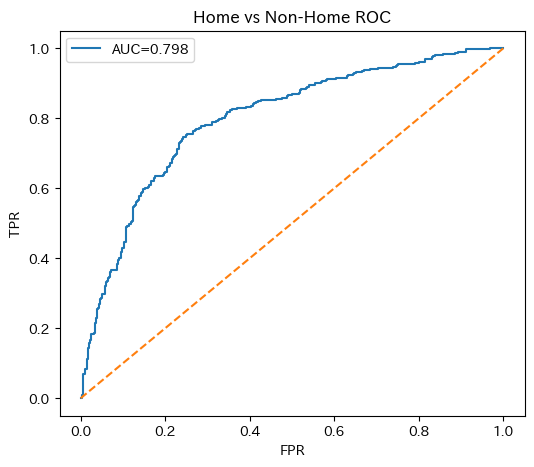

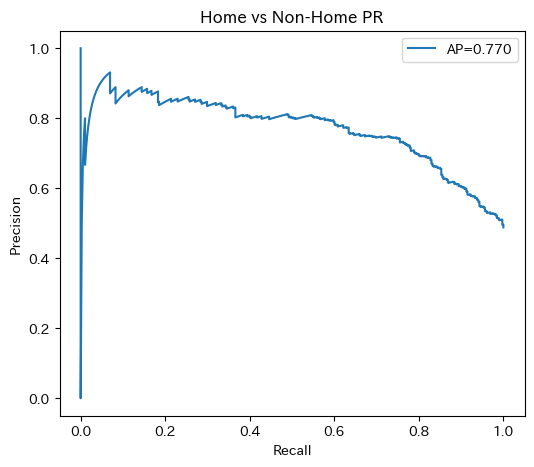

In [61]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix

# === 自宅(=1) / 非自宅(=0) へ二値化（再学習なし）===
home_name = "自宅"
home_id = (Config.CLASS_NAMES.index(home_name) if home_name in Config.CLASS_NAMES else 0)

y_bin = (yh_true == home_id).astype(int)
p_home = y_prob[:, home_id]  # P(自宅)

# しきい値の候補
prev = y_bin.mean()
thr05 = 0.5
thr_prev = np.quantile(p_home, 1 - prev)  # 予測陽性率 ≒ 有病率 に合わせる

def at(thr):
    pred = (p_home >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_bin, pred, labels=[0,1]).ravel()
    sens = tp/(tp+fn+1e-12); spec = tn/(tn+fp+1e-12)
    ppv  = tp/(tp+fp+1e-12); npv  = tn/(tn+fn+1e-12)
    acc  = (tp+tn)/(tp+tn+fp+fn); f1 = 2*tp/(2*tp+fp+fn+1e-12)
    return dict(thr=thr, sens=sens, spec=spec, ppv=ppv, npv=npv, acc=acc, f1=f1)

# しきい値不要の指標
auroc = roc_auc_score(y_bin, p_home)
ap    = average_precision_score(y_bin, p_home)
print(f"Binary(Home vs Non-Home)  AUROC={auroc:.3f}  AP={ap:.3f}")
print("thr=0.50:", at(thr05))
print("thr@prevalence:", at(thr_prev))

# ROC / PR（簡易）
fpr,tpr,_ = roc_curve(y_bin, p_home)
plt.figure(figsize=(6,5)); plt.plot(fpr,tpr,label=f"AUC={roc_auc_score(y_bin,p_home):.3f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Home vs Non-Home ROC"); plt.legend(); plt.show()

pr,rc,_ = precision_recall_curve(y_bin, p_home)
plt.figure(figsize=(6,5)); plt.plot(rc,pr,label=f"AP={average_precision_score(y_bin,p_home):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Home vs Non-Home PR"); plt.legend(); plt.show()
